# Analysis of Leios simulations at tag `leios-2025w13`

## Load dependencies

In [1]:
suppressMessages({
    require(bit64, quietly=TRUE)
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
    require(mongolite, quietly=TRUE)
    require(R.utils, quietly=TRUE)
    require(stringr, quietly=TRUE)
})

## Read results

### Elapsed time for blocks

In [2]:
if (file.exists("results/receipts.csv.gz")) {
    receipts <- fread("results/receipts.csv.gz", stringsAsFactors=TRUE)
} else {
    receipts <- data.table(mongo(url="mongodb://thelio", db="leios2025w12", collection="receipts")$find(), stringsAsFactors=TRUE)
    fwrite(receipts, "results/receipts.csv")
}
receipts %>% summary

   simulator                   network                      label          
 haskell:71439147   100-nodes      :151752544   default        :148688532  
 rust   :88752355   100-nodes-4cpus:  2688960   extended-voting:  3885618  
                    100-nodes-6cpus:  2816373   oldest-first   :  3706055  
                    100-nodes-8cpus:  2933625   peer-order     :  3911297  
                                                                           
                                                                           
                                                                           
 leios-stage-length-slots ib-generation-probability ib-body-avg-size-bytes
 Min.   :20.00            Min.   : 1.00             Min.   : 32768        
 1st Qu.:20.00            1st Qu.: 5.00             1st Qu.: 32768        
 Median :40.00            Median :25.00             Median : 98304        
 Mean   :38.84            Mean   :19.31             Mean   : 91483        
 3rd Qu.:60.00   

### CPU usage

In [3]:
if (file.exists("results/cpus.csv.gz")) {
    cpus <- fread("results/cpus.csv.gz", stringsAsFactors=TRUE)
} else {
    cpus <- data.table(mongo(url="mongodb://thelio", db="leios2025w13", collection="cpus")$find(), stringsAsFactors=TRUE)
    fwrite(cpus, "results/cpus.csv")
}
cpus %>% summary

   simulator                   network         leios-stage-length-slots
 haskell:13563022   100-nodes      :22979340   Min.   :20.00           
 rust   :11983553   100-nodes-4cpus:  849698   1st Qu.:20.00           
                    100-nodes-6cpus:  857130   Median :40.00           
                    100-nodes-8cpus:  860407   Mean   :39.59           
                                               3rd Qu.:60.00           
                                               Max.   :60.00           
                                                                       
 ib-generation-probability ib-body-avg-size-bytes eb-generation-probability
 Min.   : 1.00             Min.   : 32768         Min.   :1.500            
 1st Qu.: 1.00             1st Qu.: 32768         1st Qu.:1.500            
 Median : 5.00             Median : 98304         Median :2.000            
 Mean   :11.61             Mean   : 98382         Mean   :2.001            
 3rd Qu.:25.00             3rd Qu.:163840   

#### Scenarios present in dataset

In [4]:
receipts[, .(`Records`=.N), by=.(`simulator`, `network`, `label`)][order(`simulator`, `network`, `label`)]

simulator,network,label,Records
<fct>,<fct>,<fct>,<int>
haskell,100-nodes,default,61604634
haskell,100-nodes,extended-voting,2176351
haskell,100-nodes,oldest-first,2173297
haskell,100-nodes,peer-order,2173385
haskell,100-nodes-4cpus,default,979738
haskell,100-nodes-6cpus,default,1107266
haskell,100-nodes-8cpus,default,1224476
rust,100-nodes,default,78644940
rust,100-nodes,extended-voting,1709267


## Effect of limiting CPU

In [5]:
cpuCase <- function(network) {
    cpuLevels <- c("4 CPUs/node", "6 CPUs/node", "8 CPUs/node", "Unlimited CPUs")
    if (network == "100-nodes")
        factor("Unlimited CPUs", levels=cpuLevels)
    else if (network == "100-nodes-4cpus")
        factor("4 CPUs/node", levels=cpuLevels)
    else if (network == "100-nodes-6cpus")
        factor("6 CPUs/node", levels=cpuLevels)
    else if (network == "100-nodes-8cpus")
        factor("8 CPUs/node", levels=cpuLevels)
    else
        null
}

In [6]:
ibRate <- function(rate)
    factor(paste(rate, "IB/s"), levels=c("1 IB/s", "5 IB/s", "25 IB/s"))

In [7]:
cpuLimited <- cpus[
    `label` == "default" &
    `ib-body-avg-size-bytes` == 98304 &
    `eb-generation-probability` == 2.0 &
    `leios-stage-length-slots` == 40,
    .(
        `Total CPU [s/slot/node]`=100*sum(`duration`)
    ),
    by=.(
        `simulator`,
        `CPUs`=mapply(cpuCase, `network`),
        `IB Rate`=mapply(ibRate, `ib-generation-probability`),
        `Time [s]`=`slot`,
        `node`
    )
]
cpuLimited %>% summary

   simulator                  CPUs           IB Rate          Time [s]    
 haskell:711711   4 CPUs/node   :348920   1 IB/s :444677   Min.   :  0.0  
 rust   :687788   6 CPUs/node   :349570   5 IB/s :479994   1st Qu.:150.0  
                  8 CPUs/node   :349822   25 IB/s:474828   Median :299.0  
                  Unlimited CPUs:351187                    Mean   :299.3  
                                                           3rd Qu.:448.0  
                                                           Max.   :600.0  
                                                                          
      node         Total CPU [s/slot/node]
 node-99:  14157   Min.   :  0.00         
 node-5 :  14154   1st Qu.: 11.62         
 node-16:  14131   Median : 44.57         
 node-33:  14114   Mean   : 78.31         
 node-52:  14113   3rd Qu.:101.80         
 node-22:  14112   Max.   :535.57         
 (Other):1314718                          

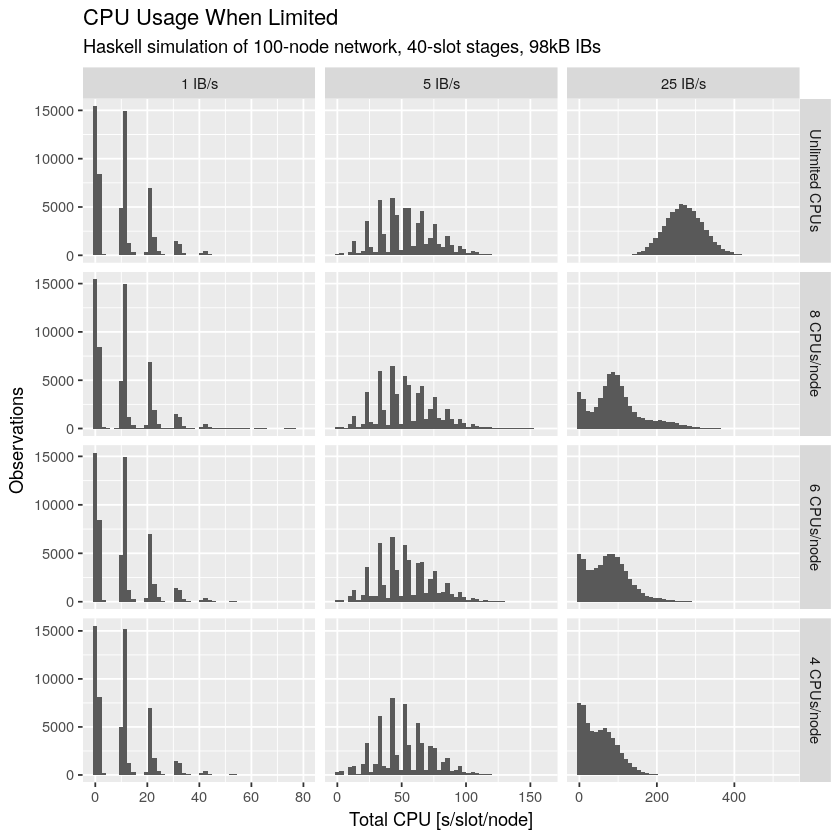

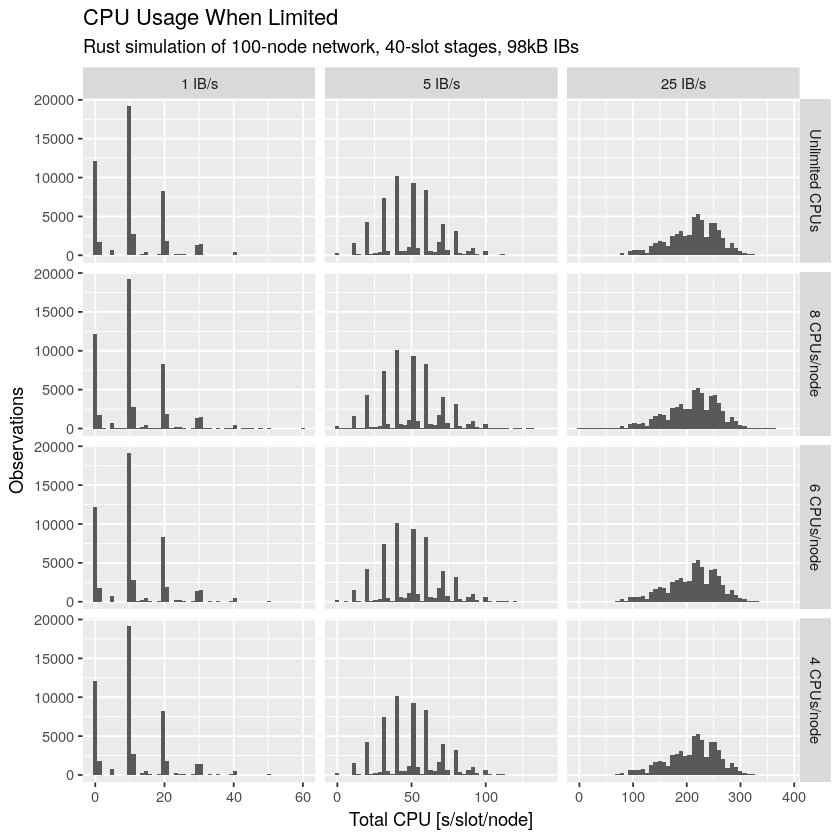

In [8]:
for (s in cpuLimited[,unique(`simulator`)%>%sort]) {
    g <- ggplot(cpuLimited[`simulator` == s], aes(x=`Total CPU [s/slot/node]`)) +
        geom_histogram(bins=50) +
        facet_grid(factor(`CPUs`, levels=levels(`CPUs`)%>%rev) ~ `IB Rate`, scales="free") +
        ylab("Observations") +
        ggtitle("CPU Usage When Limited", subtitle=paste(s %>% str_to_title, "simulation of 100-node network, 40-slot stages, 98kB IBs"))
        print(g)
        ggsave(paste0("plots/cpu-limited-histogram-", s, ".png"), units="in", width=8, height=6, dpi=150)
}

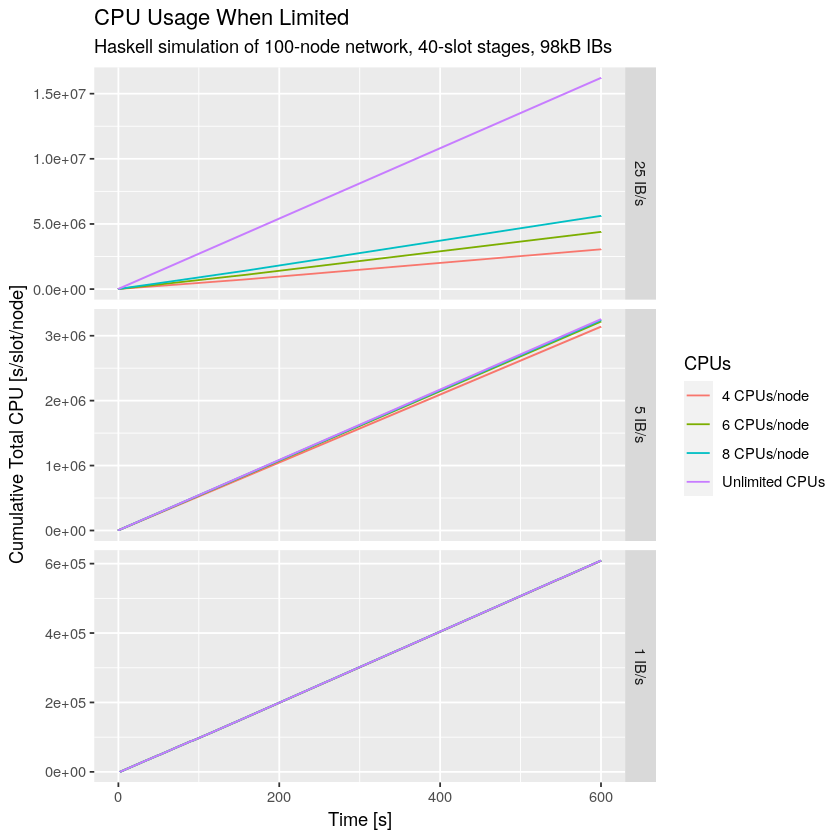

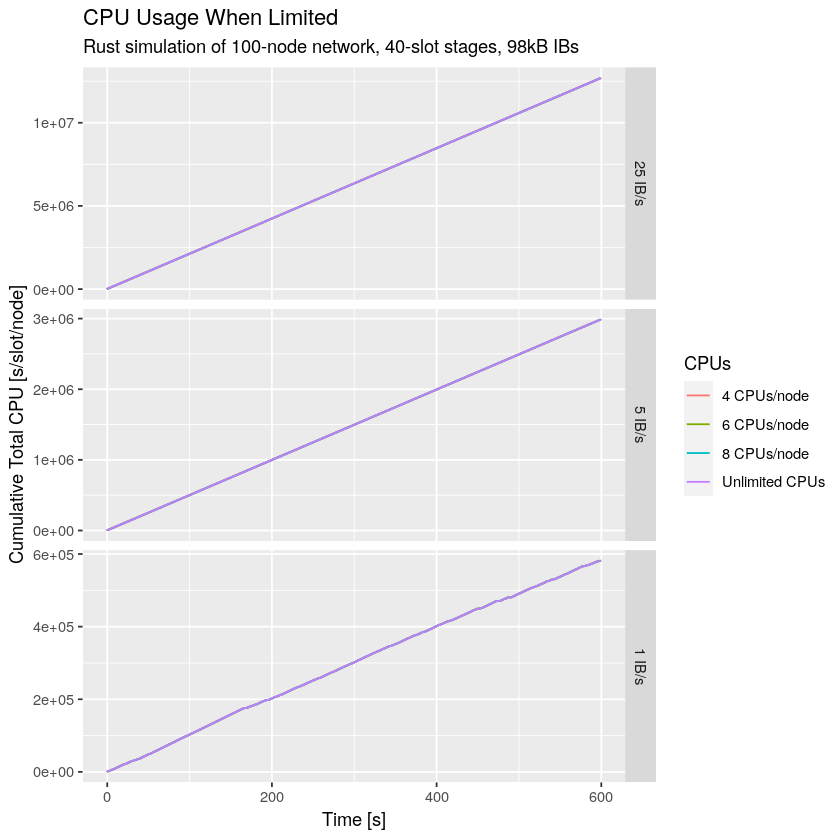

In [9]:
for (s in cpuLimited[,unique(`simulator`)%>%sort]) {
    g <- ggplot(
        cpuLimited[
            `simulator` == s, .(`Time [s]`, `Total CPU [s/slot/node]`=mean(`Total CPU [s/slot/node]`)), by=.(`CPUs`, `IB Rate`)
        ][
            order(`CPUs`, `IB Rate`, `Time [s]`)
        ][, .(`Time [s]`, `Cumulative Total CPU [s/slot/node]`=cumsum(`Total CPU [s/slot/node]`)), by=.(`CPUs`, `IB Rate`)],
        aes(x=`Time [s]`, y=`Cumulative Total CPU [s/slot/node]`, color=`CPUs`)
    ) +
        geom_line() +
        facet_grid(factor(`IB Rate`, levels=levels(`IB Rate`)%>%rev) ~ ., scales="free_y") +
        ggtitle("CPU Usage When Limited", subtitle=paste(s %>% str_to_title, "simulation of 100-node network, 40-slot stages, 98kB IBs"))
        print(g)
        ggsave(paste0("plots/cpu-limited-cumulative-", s, ".png"), units="in", width=8, height=6, dpi=150)
}

In [10]:
receiptLimited <- receipts[
    `label` == "default" &
    `ib-body-avg-size-bytes` == 98304 &
    `eb-generation-probability` == 2.0 &
    `leios-stage-length-slots` == 40 &
    `kind` == "IB",
    .(
        `simulator`,
        `CPUs`=mapply(cpuCase, `network`),
        `IB Rate`=mapply(ibRate, `ib-generation-probability`),
        `elapsed`,
        `item`,
        `sent`,
        `received`
    )
]
receiptLimited %>% summary

   simulator                   CPUs            IB Rate           elapsed       
 haskell:4132015   4 CPUs/node   :2249155   1 IB/s : 437914   Min.   :  0.000  
 rust   :6430349   6 CPUs/node   :2376450   5 IB/s :2364130   1st Qu.:  1.190  
                   8 CPUs/node   :2493693   25 IB/s:7760320   Median :  1.781  
                   Unlimited CPUs:3443066                     Mean   :  1.953  
                                                              3rd Qu.:  2.455  
                                                              Max.   :377.912  
                                                                               
      item               sent           received     
 16-0   :    1197   Min.   :  0.13   Min.   :  0.13  
 66-0   :    1195   1st Qu.:148.13   1st Qu.:150.14  
 86-0   :    1195   Median :297.13   Median :299.37  
 35-0   :    1194   Mean   :297.92   Mean   :299.87  
 41-0   :    1194   3rd Qu.:447.13   3rd Qu.:449.30  
 78-0   :    1194   Max.   :599.13  

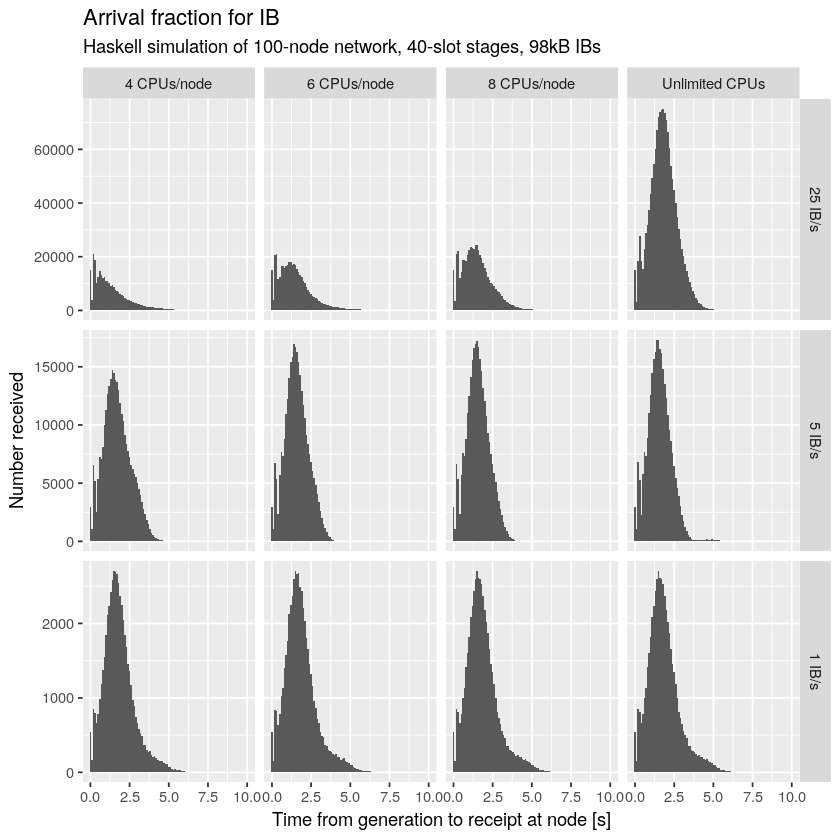

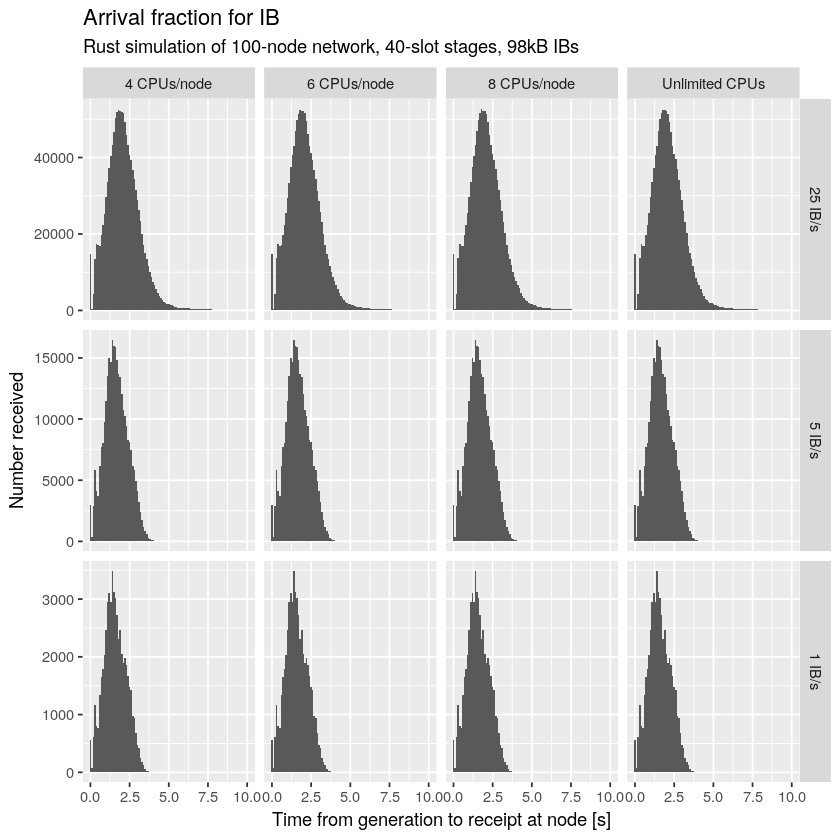

In [11]:
for (s in receiptLimited[,unique(`simulator`)%>%sort]) {
    g <- ggplot(receiptLimited[`simulator` == s], aes(x=`elapsed`)) +
        geom_histogram(binwidth=0.1) +
        coord_cartesian(xlim=c(0,10)) +
        facet_grid(factor(`IB Rate`, levels=levels(`IB Rate`)%>%rev) ~ `CPUs`, scales="free") +
        xlab("Time from generation to receipt at node [s]") +
        ylab("Number received") +
        ggtitle("Arrival fraction for IB", subtitle=paste(s %>% str_to_title, "simulation of 100-node network, 40-slot stages, 98kB IBs"))
        print(g)
        ggsave(paste0("plots/receipt-limited-histogram-", s, ".png"), units="in", width=8, height=6, dpi=150)
}

In [12]:
arrivalLimited <- receiptLimited[
    !is.na(`received`) & `sent` <= 540,
    .(`received`=as.numeric(.N)),
    by=.(`simulator`, `CPUs`, `IB Rate`, `sent`, `item`)
][,
    .(`total`=as.numeric(.N), `received`=sum(`received`)),
    by=.(`simulator`, `CPUs`, `IB Rate`, `sent`)
][,
    .(`received`=sum(`received`)/sum(`total`)),
    by=.(`simulator`, `CPUs`, `IB Rate`, `sent`)
]

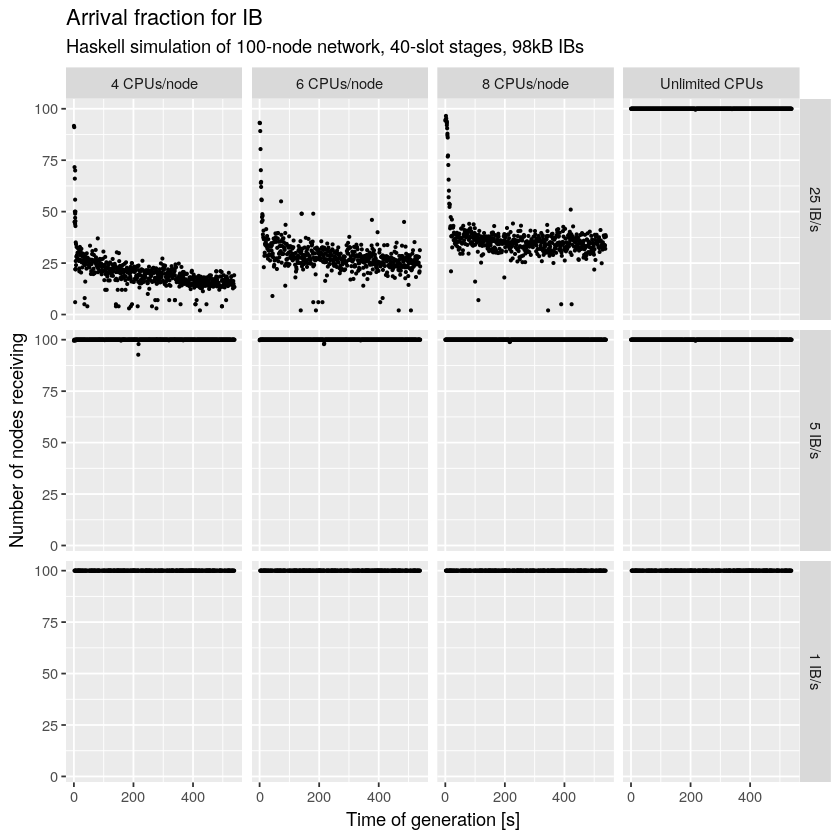

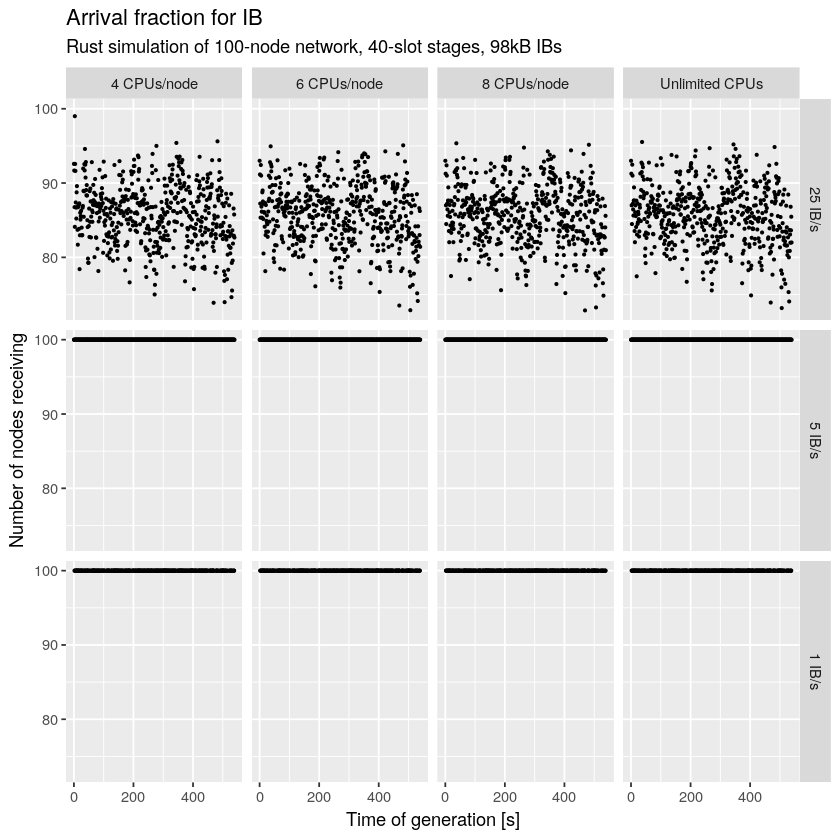

In [13]:
for (s in arrivalLimited[,unique(`simulator`)%>%sort]) {
    g <- ggplot(
        arrivalLimited[`simulator` == s], 
        aes(x=`sent`, y=`received`)
    ) +
        geom_point(size=0.5) +
        facet_grid(factor(`IB Rate`, levels=levels(`IB Rate`)%>%rev)  ~ `CPUs`) +
        xlab("Time of generation [s]") +
        ylab("Number of nodes receiving") +
        ggtitle("Arrival fraction for IB", subtitle=paste(s %>% str_to_title, "simulation of 100-node network, 40-slot stages, 98kB IBs"))
    print(g)
    ggsave(paste0("plots/arrival-limited-IB-", s, ".png"), units="in", width=8, height=6, dpi=150)
}

## Effect of delivery order

In [14]:
orderCase <- function(label) {
    labelLevels <- c("oldest-first", "peer-order", "freshest-first")
    if (label == "default")
        factor("freshest-first", levels=labelLevels)
    else
        factor(label, levels=labelLevels)
}    

In [15]:
receiptOrdered <- receipts[
    `label` %in% c("default", "oldest-first", "peer-order") &
    `network` == "100-nodes" &
    `ib-body-avg-size-bytes` == 98304 &
    `eb-generation-probability` == 2.0 &
    `leios-stage-length-slots` == 40 &
    `kind` == "IB",
    .(
        `simulator`,
        `Ordering`=mapply(orderCase, `label`),
        `IB Rate`=mapply(ibRate, `ib-generation-probability`),
        `elapsed`,
        `item`,
        `sent`,
        `received`
    )
]
receiptOrdered %>% summary

   simulator                 Ordering          IB Rate           elapsed       
 haskell:5505926   oldest-first  :3265649   1 IB/s : 328440   Min.   :  0.000  
 rust   :4674265   peer-order    :3471476   5 IB/s :1773286   1st Qu.:  1.339  
                   freshest-first:3443066   25 IB/s:8078465   Median :  1.968  
                                                              Mean   :  9.031  
                                                              3rd Qu.:  2.800  
                                                              Max.   :389.866  
                                                                               
      item               sent           received     
 0-0    :     900   Min.   :  0.13   Min.   :  0.13  
 0-1    :     900   1st Qu.:147.13   1st Qu.:153.76  
 0-4    :     900   Median :290.13   Median :302.93  
 0-7    :     900   Mean   :293.65   Mean   :302.68  
 1-1    :     900   3rd Qu.:439.13   3rd Qu.:451.46  
 1-13   :     900   Max.   :599.13  

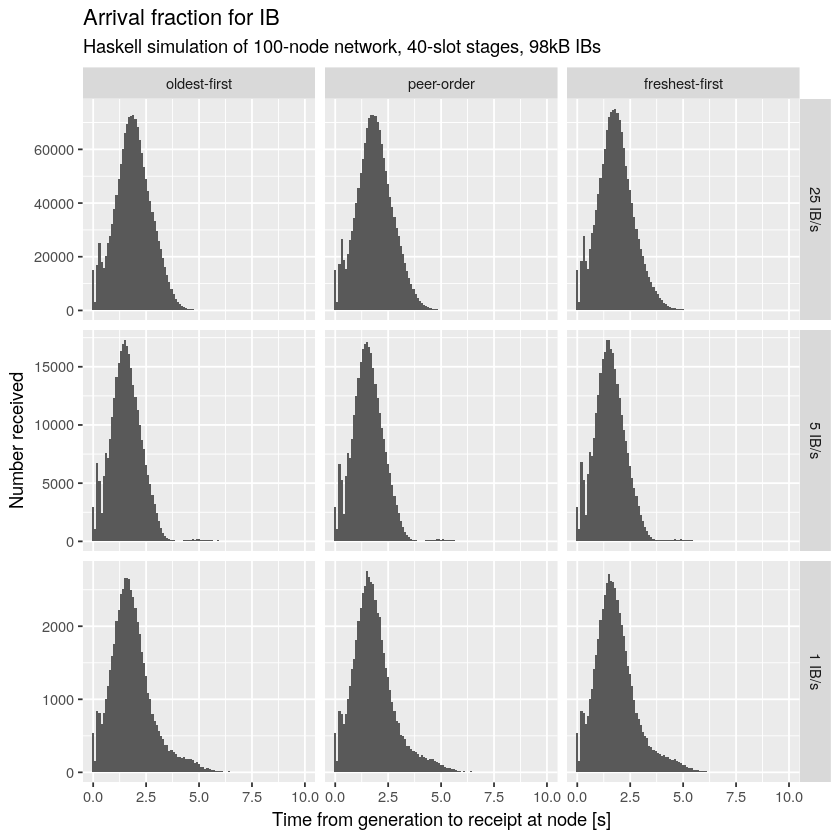

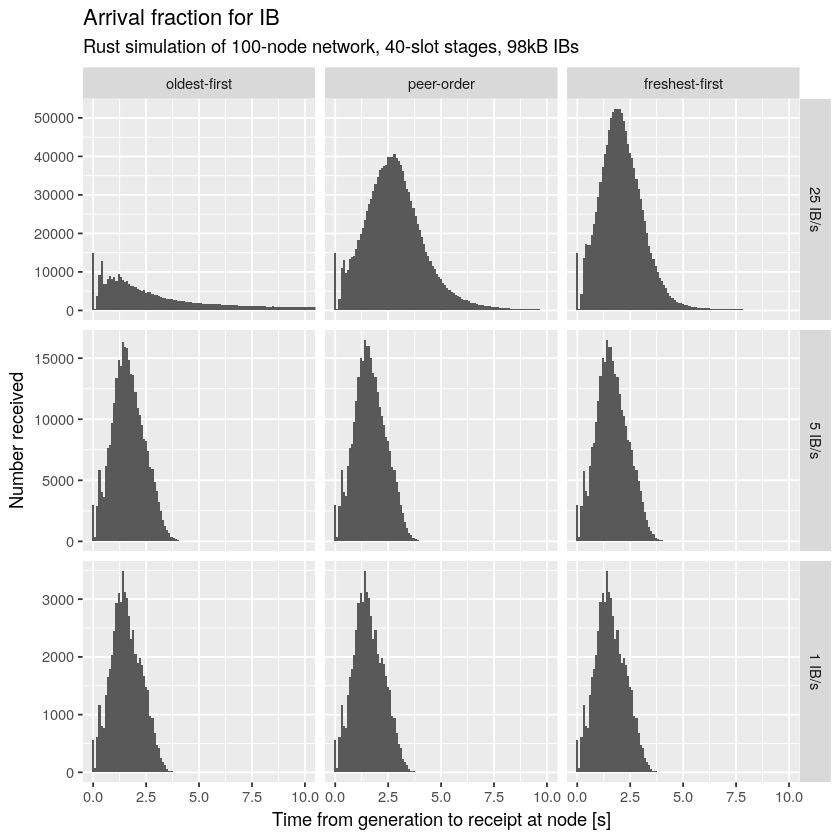

In [16]:
for (s in receiptOrdered[,unique(`simulator`)%>%sort]) {
    g <- ggplot(receiptOrdered[`simulator` == s], aes(x=`elapsed`)) +
        geom_histogram(binwidth=0.1) +
        coord_cartesian(xlim=c(0,10)) +
        facet_grid(factor(`IB Rate`, levels=levels(`IB Rate`)%>%rev) ~ `Ordering`, scales="free") +
        xlab("Time from generation to receipt at node [s]") +
        ylab("Number received") +
        ggtitle("Arrival fraction for IB", subtitle=paste(s %>% str_to_title, "simulation of 100-node network, 40-slot stages, 98kB IBs"))
        print(g)
        ggsave(paste0("plots/receipt-ordered-", s, ".png"), units="in", width=8, height=6, dpi=150)
}

In [17]:
arrivalOrdered <- receiptOrdered[
    !is.na(`received`) & `sent` <= 540,
    .(`received`=as.numeric(.N)),
    by=.(`simulator`, `Ordering`, `IB Rate`, `sent`, `item`)
][,
    .(`total`=as.numeric(.N), `received`=sum(`received`)),
    by=.(`simulator`, `Ordering`, `IB Rate`, `sent`)
][,
    .(`received`=sum(`received`)/sum(`total`)),
    by=.(`simulator`, `Ordering`, `IB Rate`, `sent`)
]

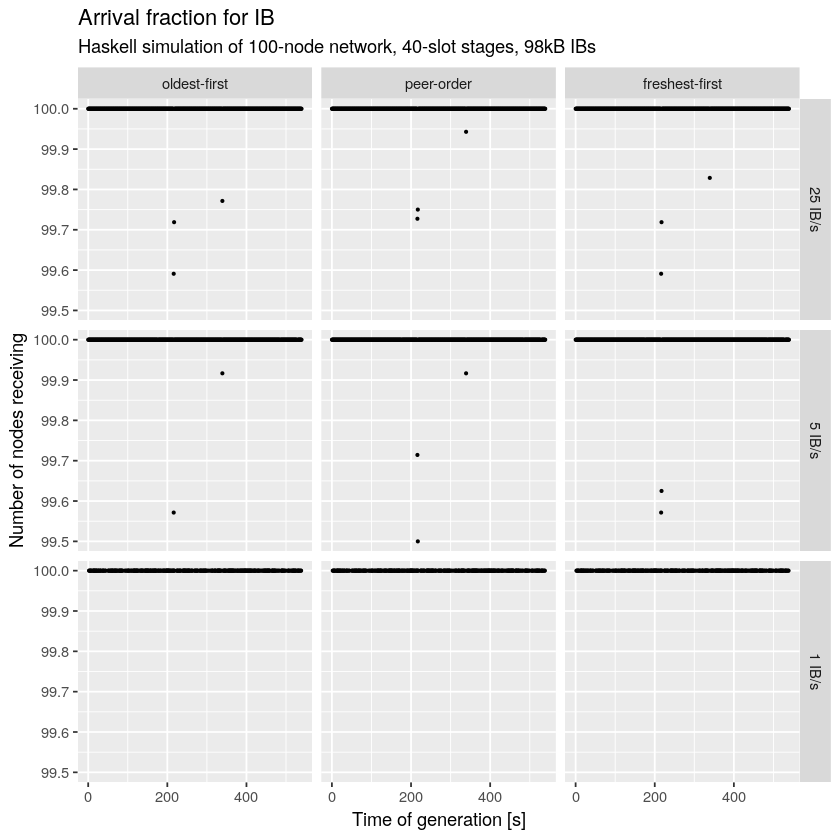

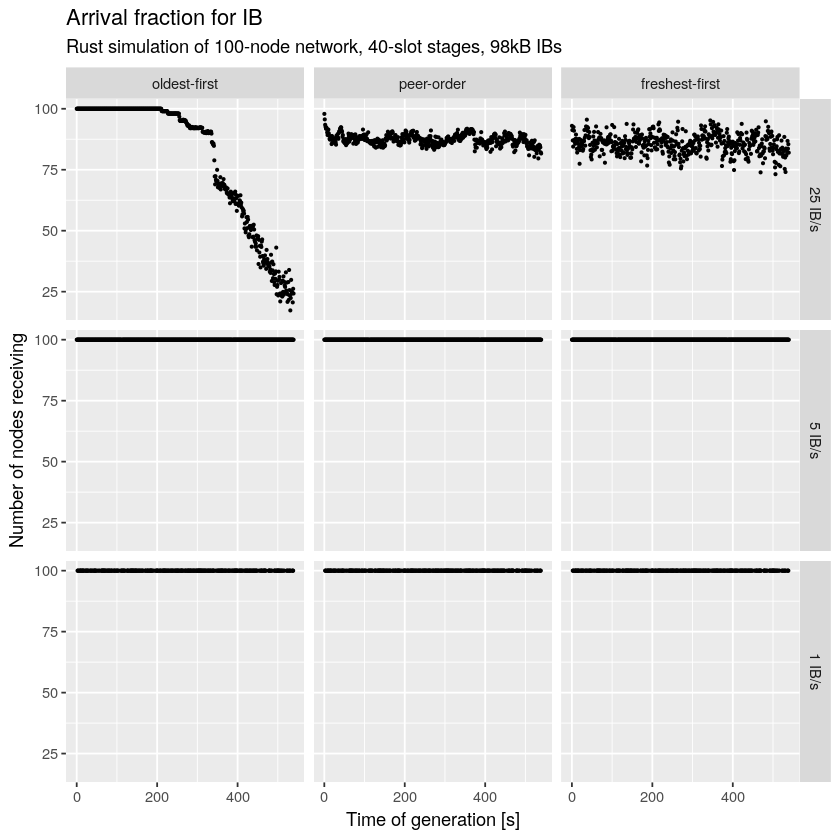

In [18]:
for (s in arrivalOrdered[,unique(`simulator`)%>%sort]) {
    g <- ggplot(
        arrivalOrdered[`simulator` == s], 
        aes(x=`sent`, y=`received`)
    ) +
        geom_point(size=0.5) +
        facet_grid(factor(`IB Rate`, levels=levels(`IB Rate`)%>%rev)  ~ `Ordering`) +
        xlab("Time of generation [s]") +
        ylab("Number of nodes receiving") +
        ggtitle("Arrival fraction for IB", subtitle=paste(s %>% str_to_title, "simulation of 100-node network, 40-slot stages, 98kB IBs"))
    print(g)
    ggsave(paste0("plots/arrival-ordered-IB-", s, ".png"), units="in", width=8, height=6, dpi=150)
}

## Effect of extended voting

In [19]:
extendedCase <- function(label) {
    labelLevels <- c("Without extended voting", "With extended voting")
    if (label == "default")
        factor("Without extended voting", levels=labelLevels)
    else if (label == "extended-voting")
        factor("With extended voting", levels=labelLevels)
    else
        null
}    

In [20]:
receiptExtended <- receipts[
    `label` %in% c("default", "extended-voting") &
    `network` == "100-nodes" &
    `ib-body-avg-size-bytes` == 98304 &
    `eb-generation-probability` == 2.0 &
    `leios-stage-length-slots` == 40 &
    `kind` == "VT",
    .(
        `simulator`,
        `Extended`=mapply(extendedCase, `label`),
        `IB Rate`=mapply(ibRate, `ib-generation-probability`),
        `elapsed`,
        `item`,
        `sent`,
        `received`
    )
]
receiptExtended %>% summary

   simulator                         Extended         IB Rate      
 haskell:655718   Without extended voting:410752   1 IB/s :283872  
 rust   :168600   With extended voting   :413566   5 IB/s :281840  
                                                   25 IB/s:258606  
                                                                   
                                                                   
                                                                   
                                                                   
    elapsed               item             sent          received    
 Min.   :0.0000   68-node-75:   600   Min.   : 40.0   Min.   : 40.0  
 1st Qu.:0.5733   0-8       :   400   1st Qu.:188.0   1st Qu.:189.4  
 Median :0.9129   0-9       :   400   Median :329.0   Median :329.6  
 Mean   :0.9924   1-11      :   400   Mean   :324.8   Mean   :325.8  
 3rd Qu.:1.3584   1-14      :   400   3rd Qu.:460.0   3rd Qu.:461.4  
 Max.   :5.9329   1-9       :   400 

In [21]:
receiptExtended[,
    .(`Mean time from generation to receipt at node [s]`=mean(`elapsed`, na.rm=TRUE)),
    by=.(`simulator`, `Extended`)
]

simulator,Extended,Mean time from generation to receipt at node [s]
<fct>,<fct>,<dbl>
haskell,With extended voting,1.0228966
haskell,Without extended voting,1.0164911
rust,Without extended voting,0.8864033
rust,With extended voting,0.8864033


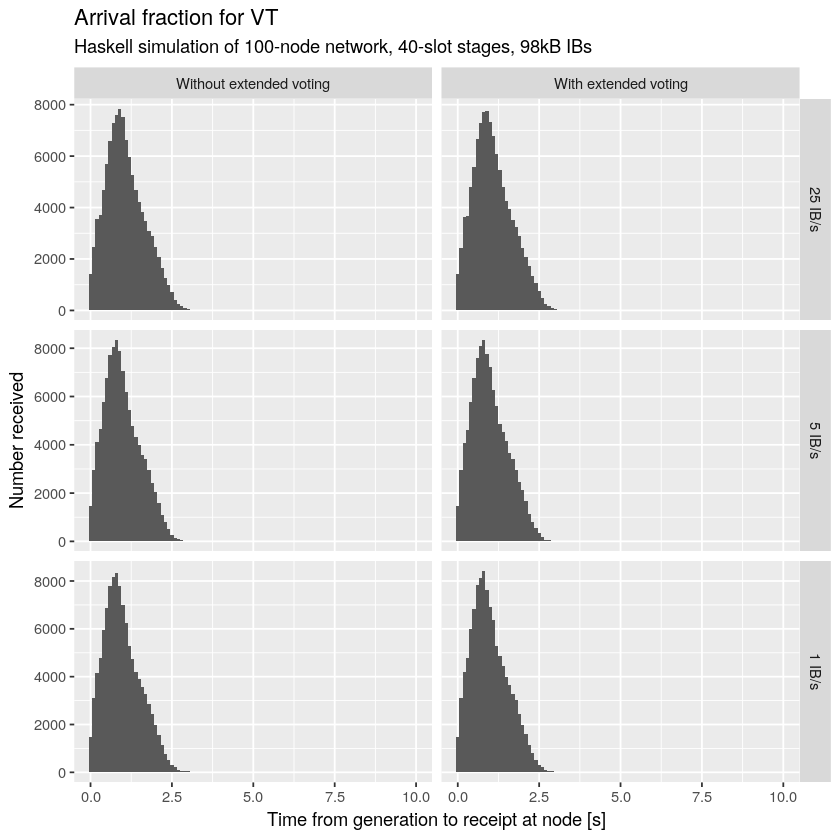

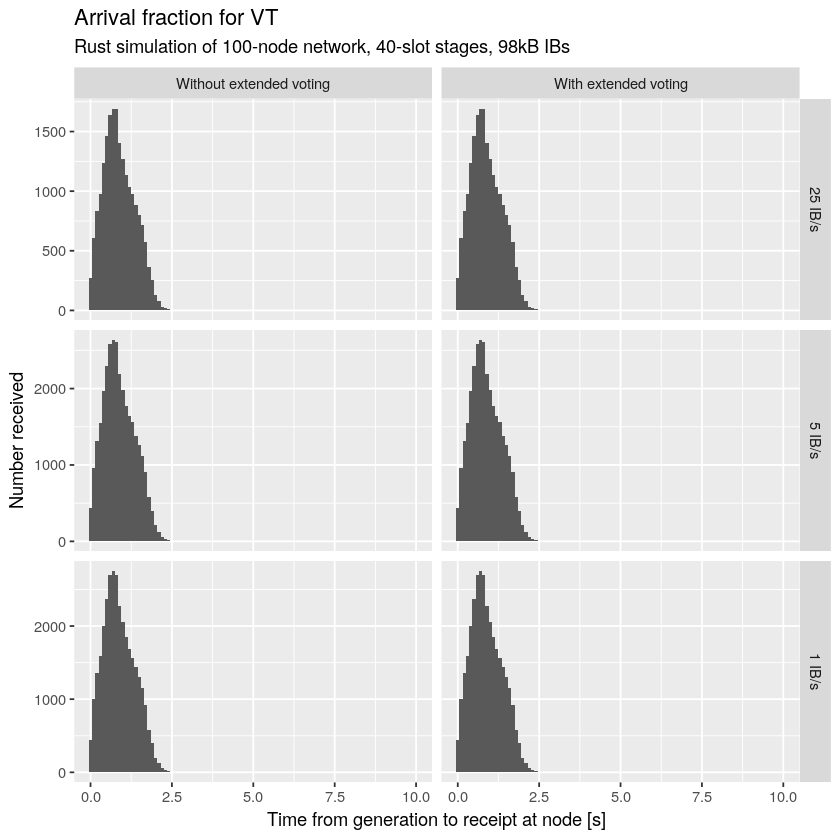

In [22]:
for (s in receiptExtended[,unique(`simulator`)%>%sort]) {
    g <- ggplot(receiptExtended[`simulator` == s & !is.na(`elapsed`)], aes(x=`elapsed`)) +
        geom_histogram(binwidth=0.1) +
        coord_cartesian(xlim=c(0,10)) +
        facet_grid(factor(`IB Rate`, levels=levels(`IB Rate`)%>%rev) ~ `Extended`, scales="free") +
        xlab("Time from generation to receipt at node [s]") +
        ylab("Number received") +
        ggtitle("Arrival fraction for VT", subtitle=paste(s %>% str_to_title, "simulation of 100-node network, 40-slot stages, 98kB IBs"))
        print(g)
        ggsave(paste0("plots/receipt-ordered-", s, ".png"), units="in", width=8, height=6, dpi=150)
}

In [23]:
arrivalExtended <- receiptExtended[
    !is.na(`received`) & `sent` <= 540,
    .(`received`=as.numeric(.N)),
    by=.(`simulator`, `Extended`, `IB Rate`, `sent`, `item`)
][,
    .(`total`=as.numeric(.N), `received`=sum(`received`)),
    by=.(`simulator`, `Extended`, `IB Rate`, `sent`)
][,
    .(`received`=sum(`received`)/sum(`total`)),
    by=.(`simulator`, `Extended`, `IB Rate`, `sent`)
]

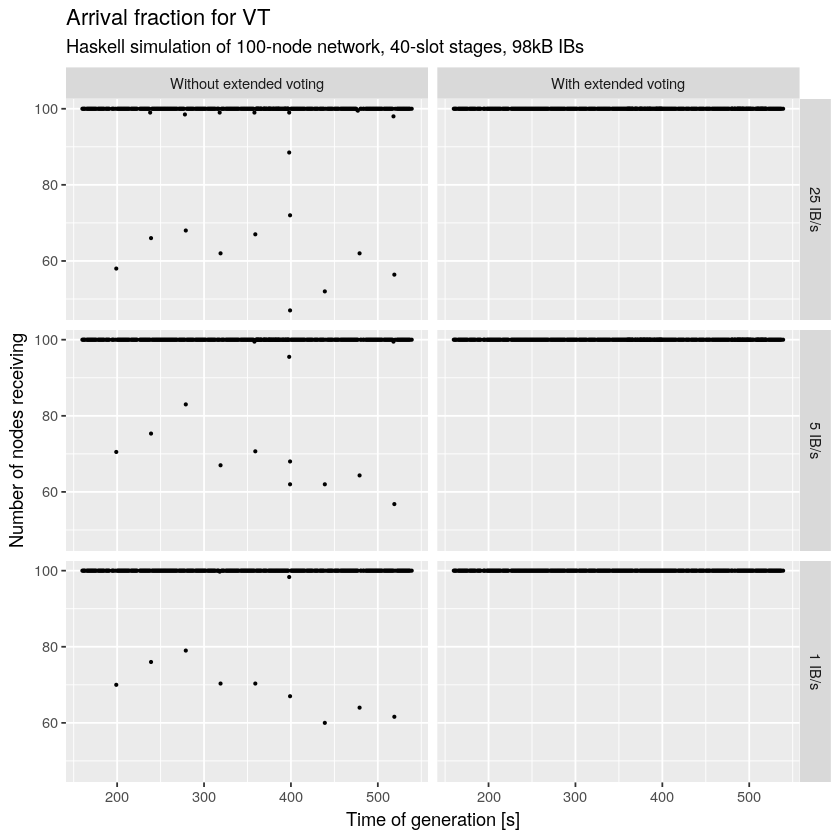

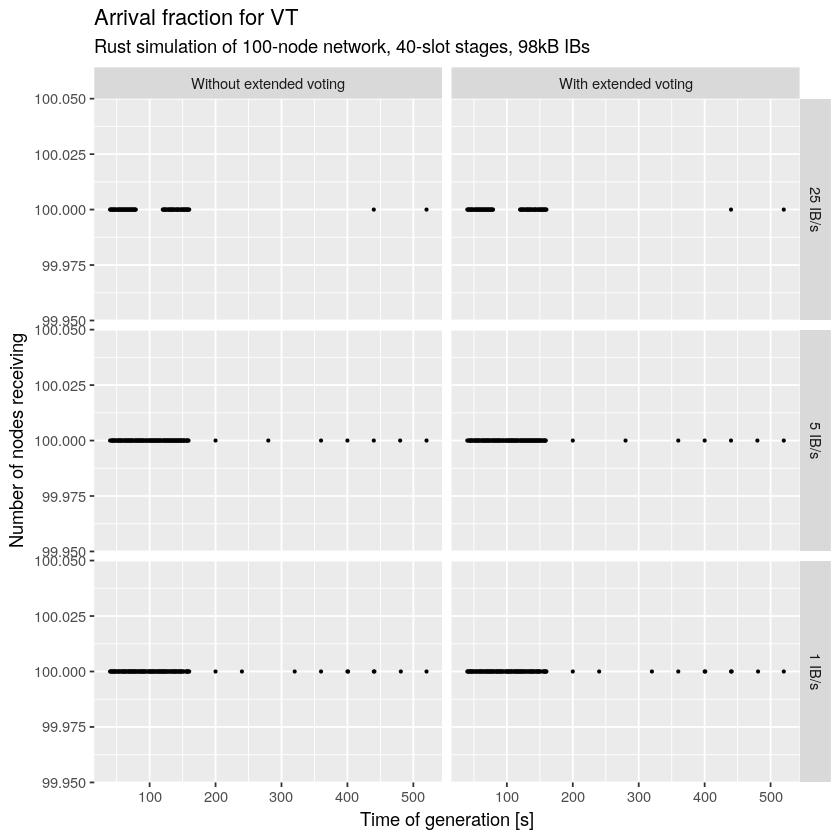

In [24]:
for (s in arrivalExtended[,unique(`simulator`)%>%sort]) {
    g <- ggplot(
        arrivalExtended[`simulator` == s], 
        aes(x=`sent`, y=`received`)
    ) +
        geom_point(size=0.5) +
        facet_grid(factor(`IB Rate`, levels=levels(`IB Rate`)%>%rev)  ~ `Extended`) +
        xlab("Time of generation [s]") +
        ylab("Number of nodes receiving") +
        ggtitle("Arrival fraction for VT", subtitle=paste(s %>% str_to_title, "simulation of 100-node network, 40-slot stages, 98kB IBs"))
    print(g)
    ggsave(paste0("plots/arrival-extended-VT-", s, ".png"), units="in", width=8, height=6, dpi=150)
}

## General diagnostics

#### Compare the distributions of elapsed times

In [25]:
receiptScenario <- receipts[
    order(`simulator`, `label`, `network`, `leios-stage-length-slots`, `ib-generation-probability`, `ib-body-avg-size-bytes`, `eb-generation-probability`)
][
    !is.na(`elapsed`),
    .(`elapsed`),
    .(
        `simulator`,
        `scenario`=paste(`label`, `network`, `leios-stage-length-slots`, `ib-generation-probability`, `ib-body-avg-size-bytes`, `eb-generation-probability`, sep=" | "),
        `kind`
    )
]

In [26]:
options(repr.plot.width=20, repr.plot.height=15)

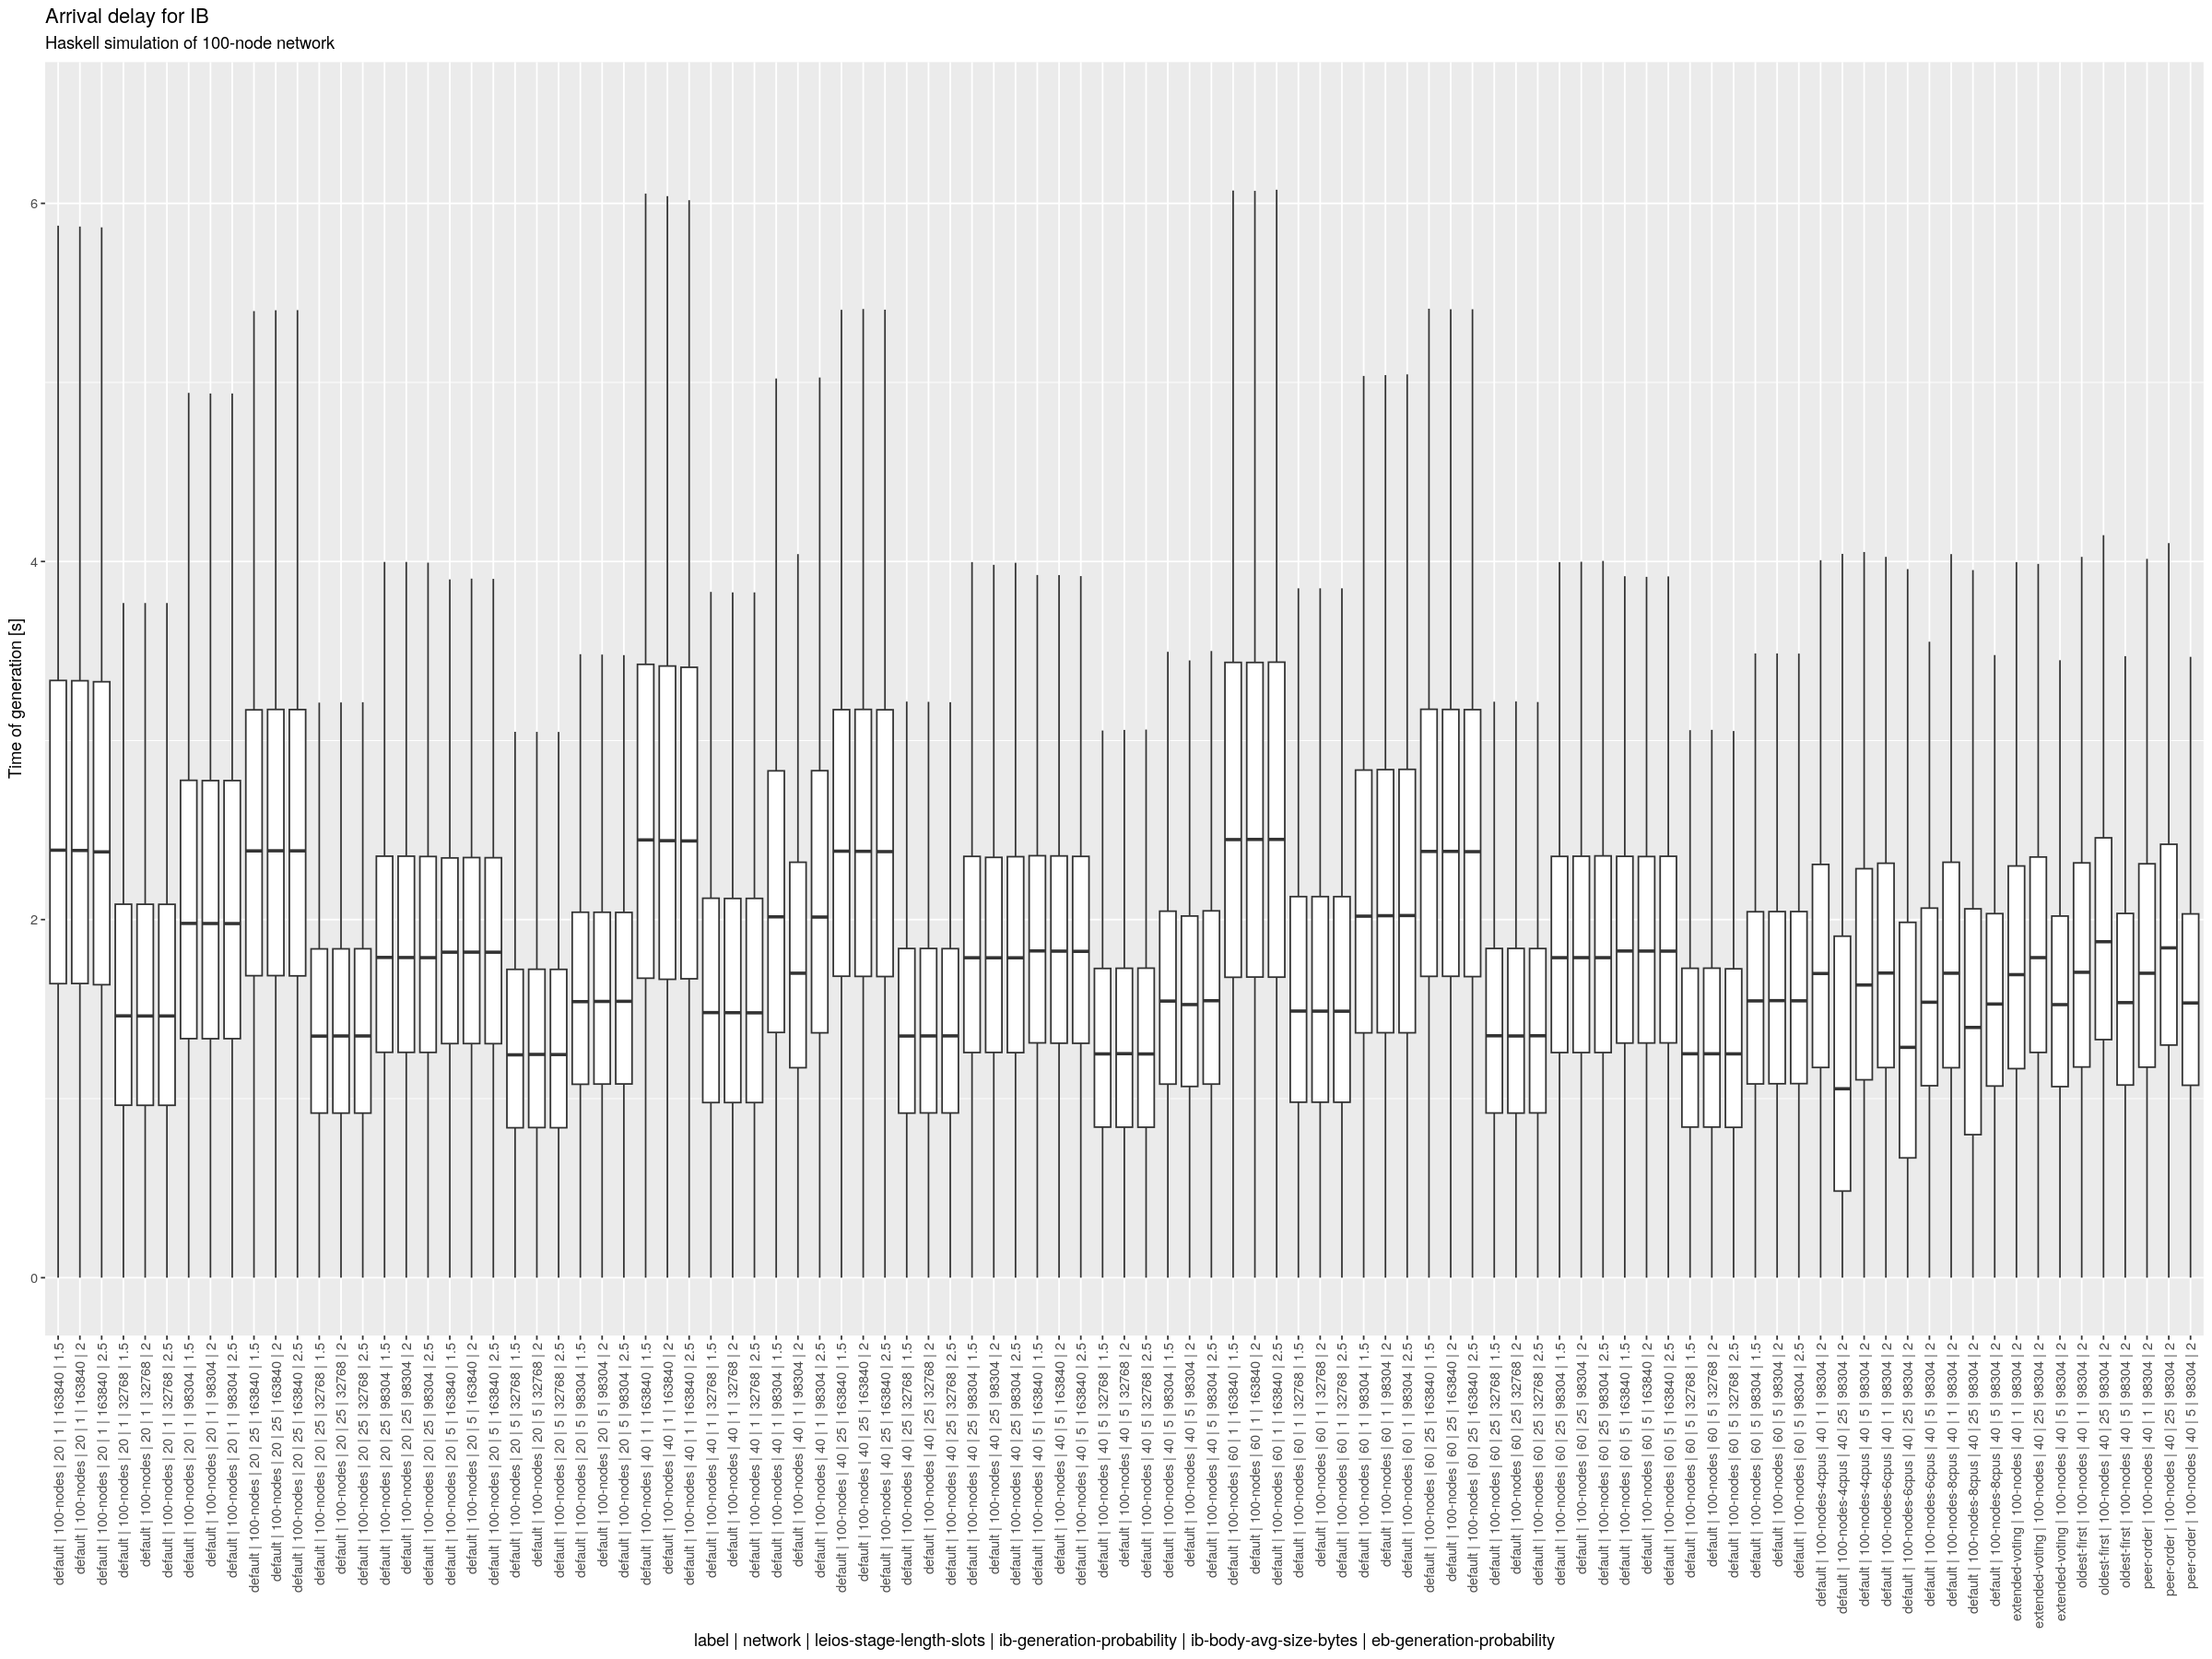

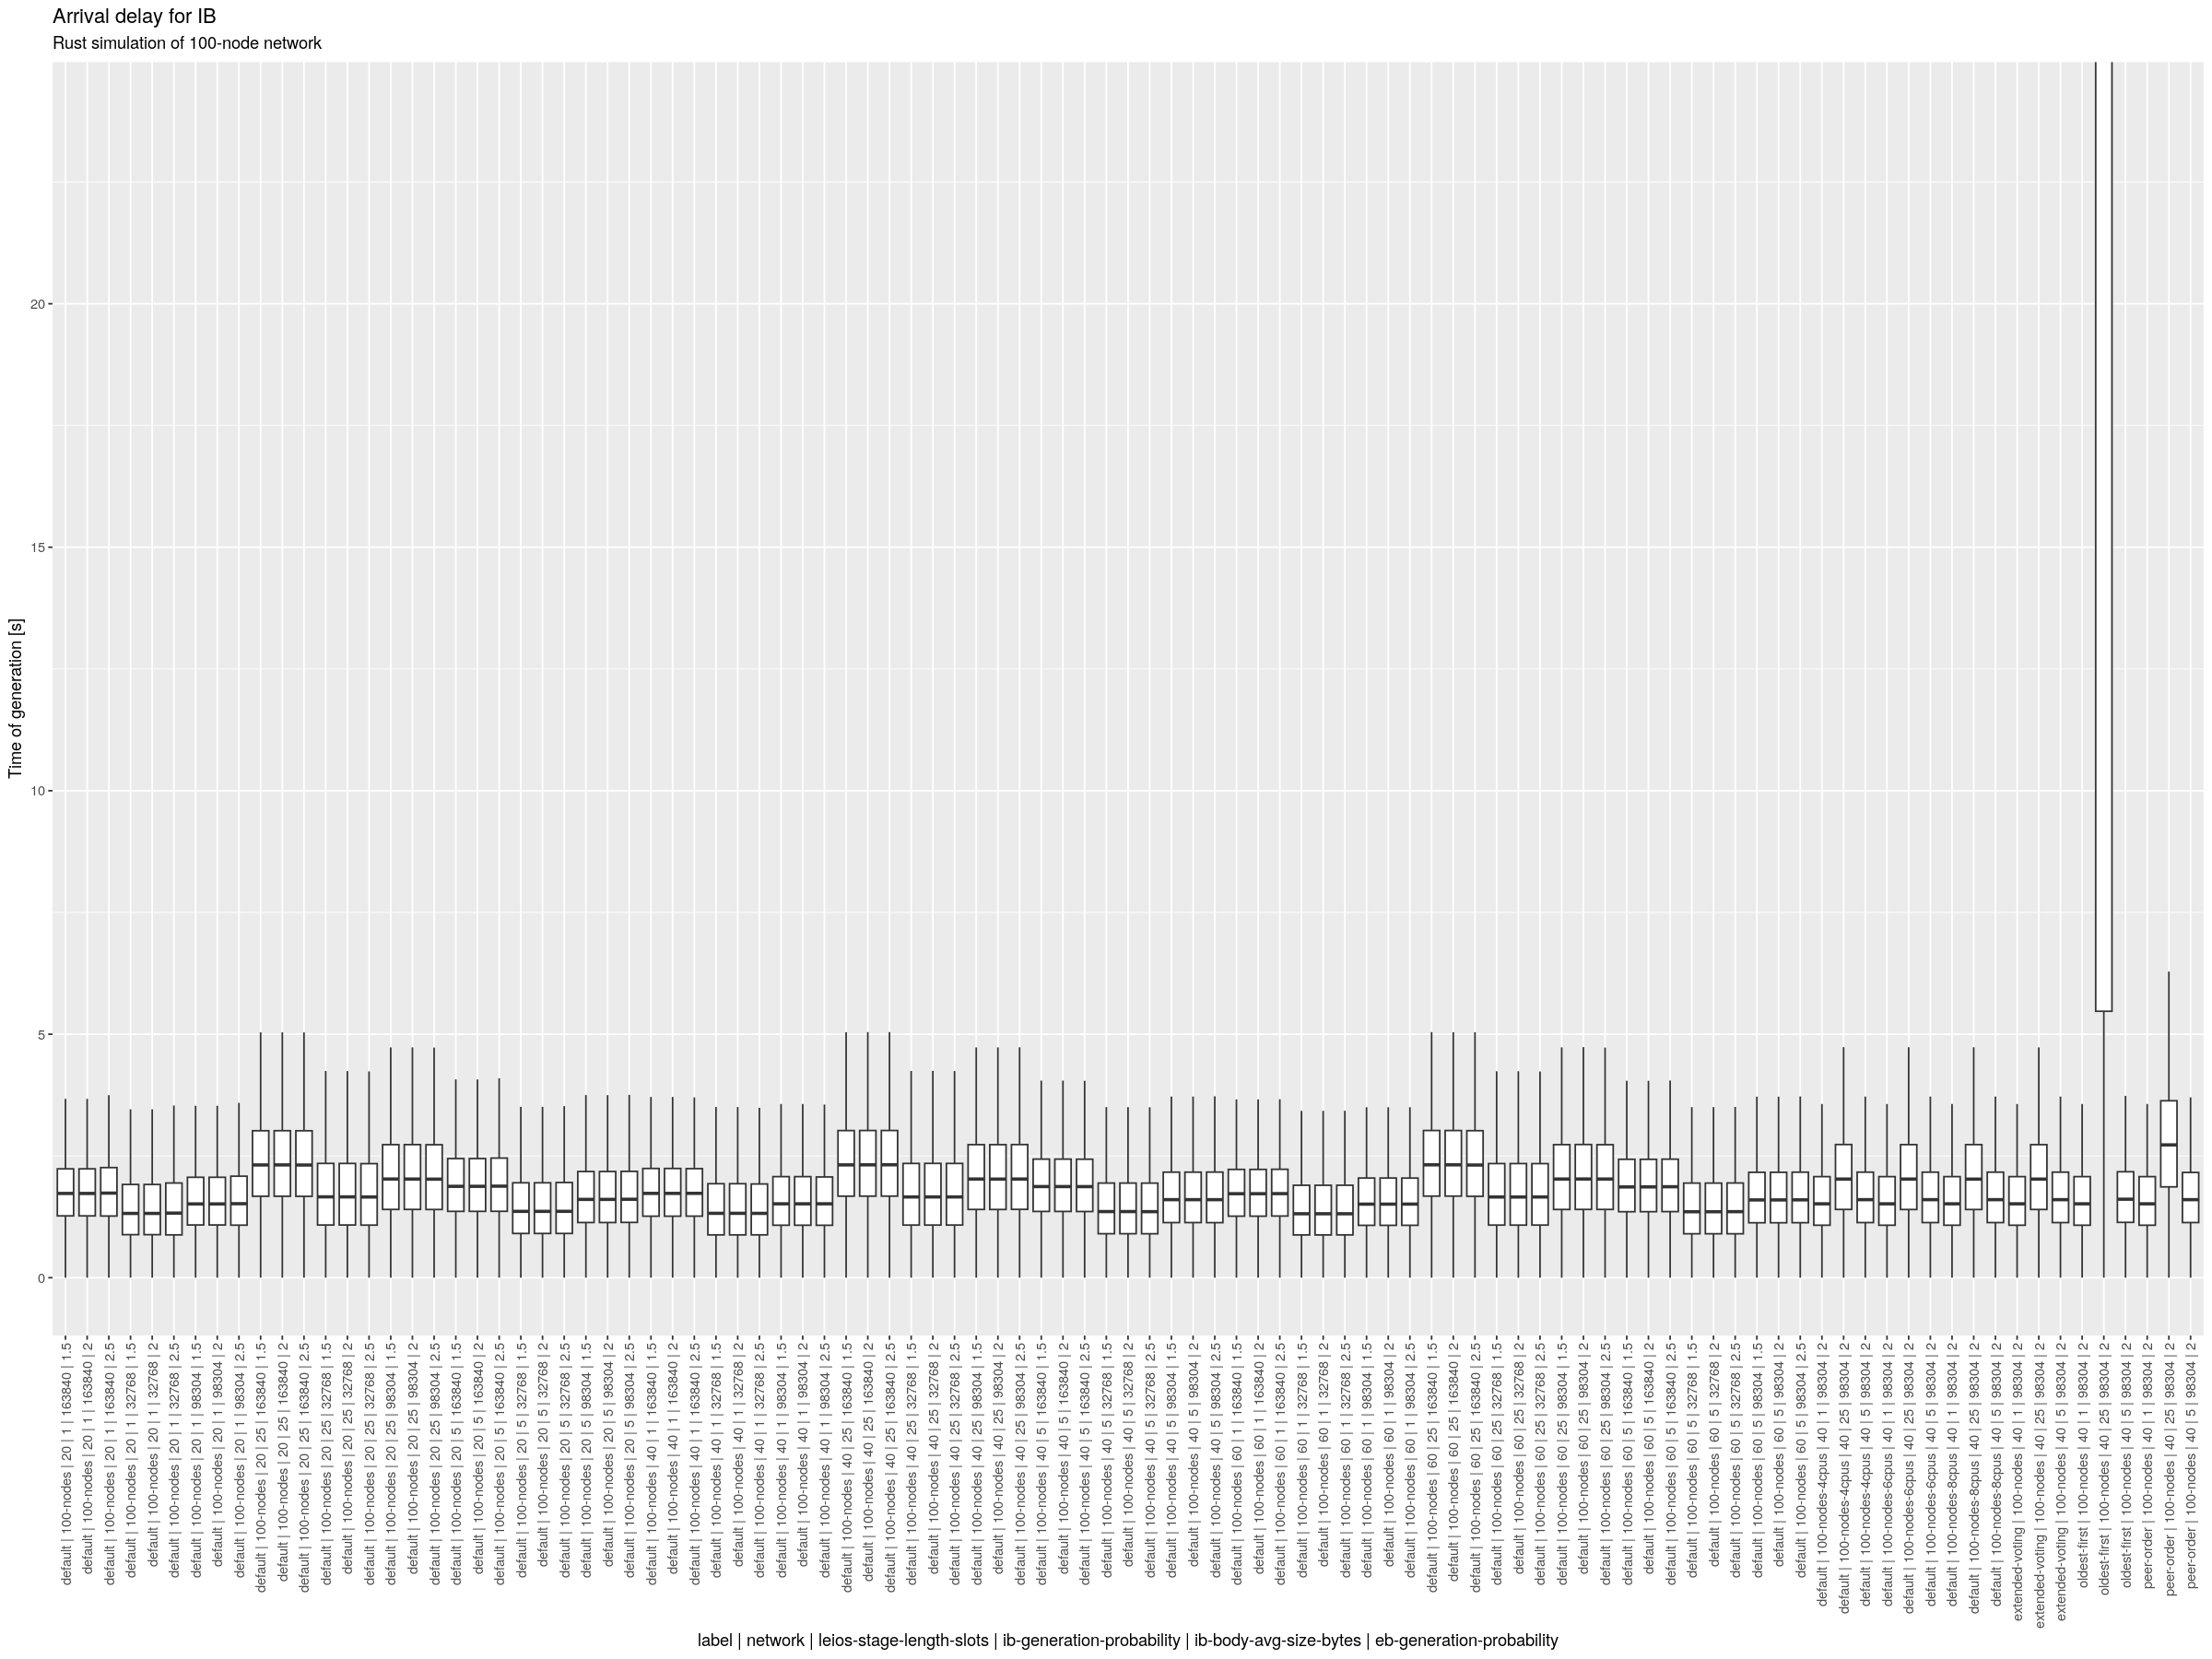

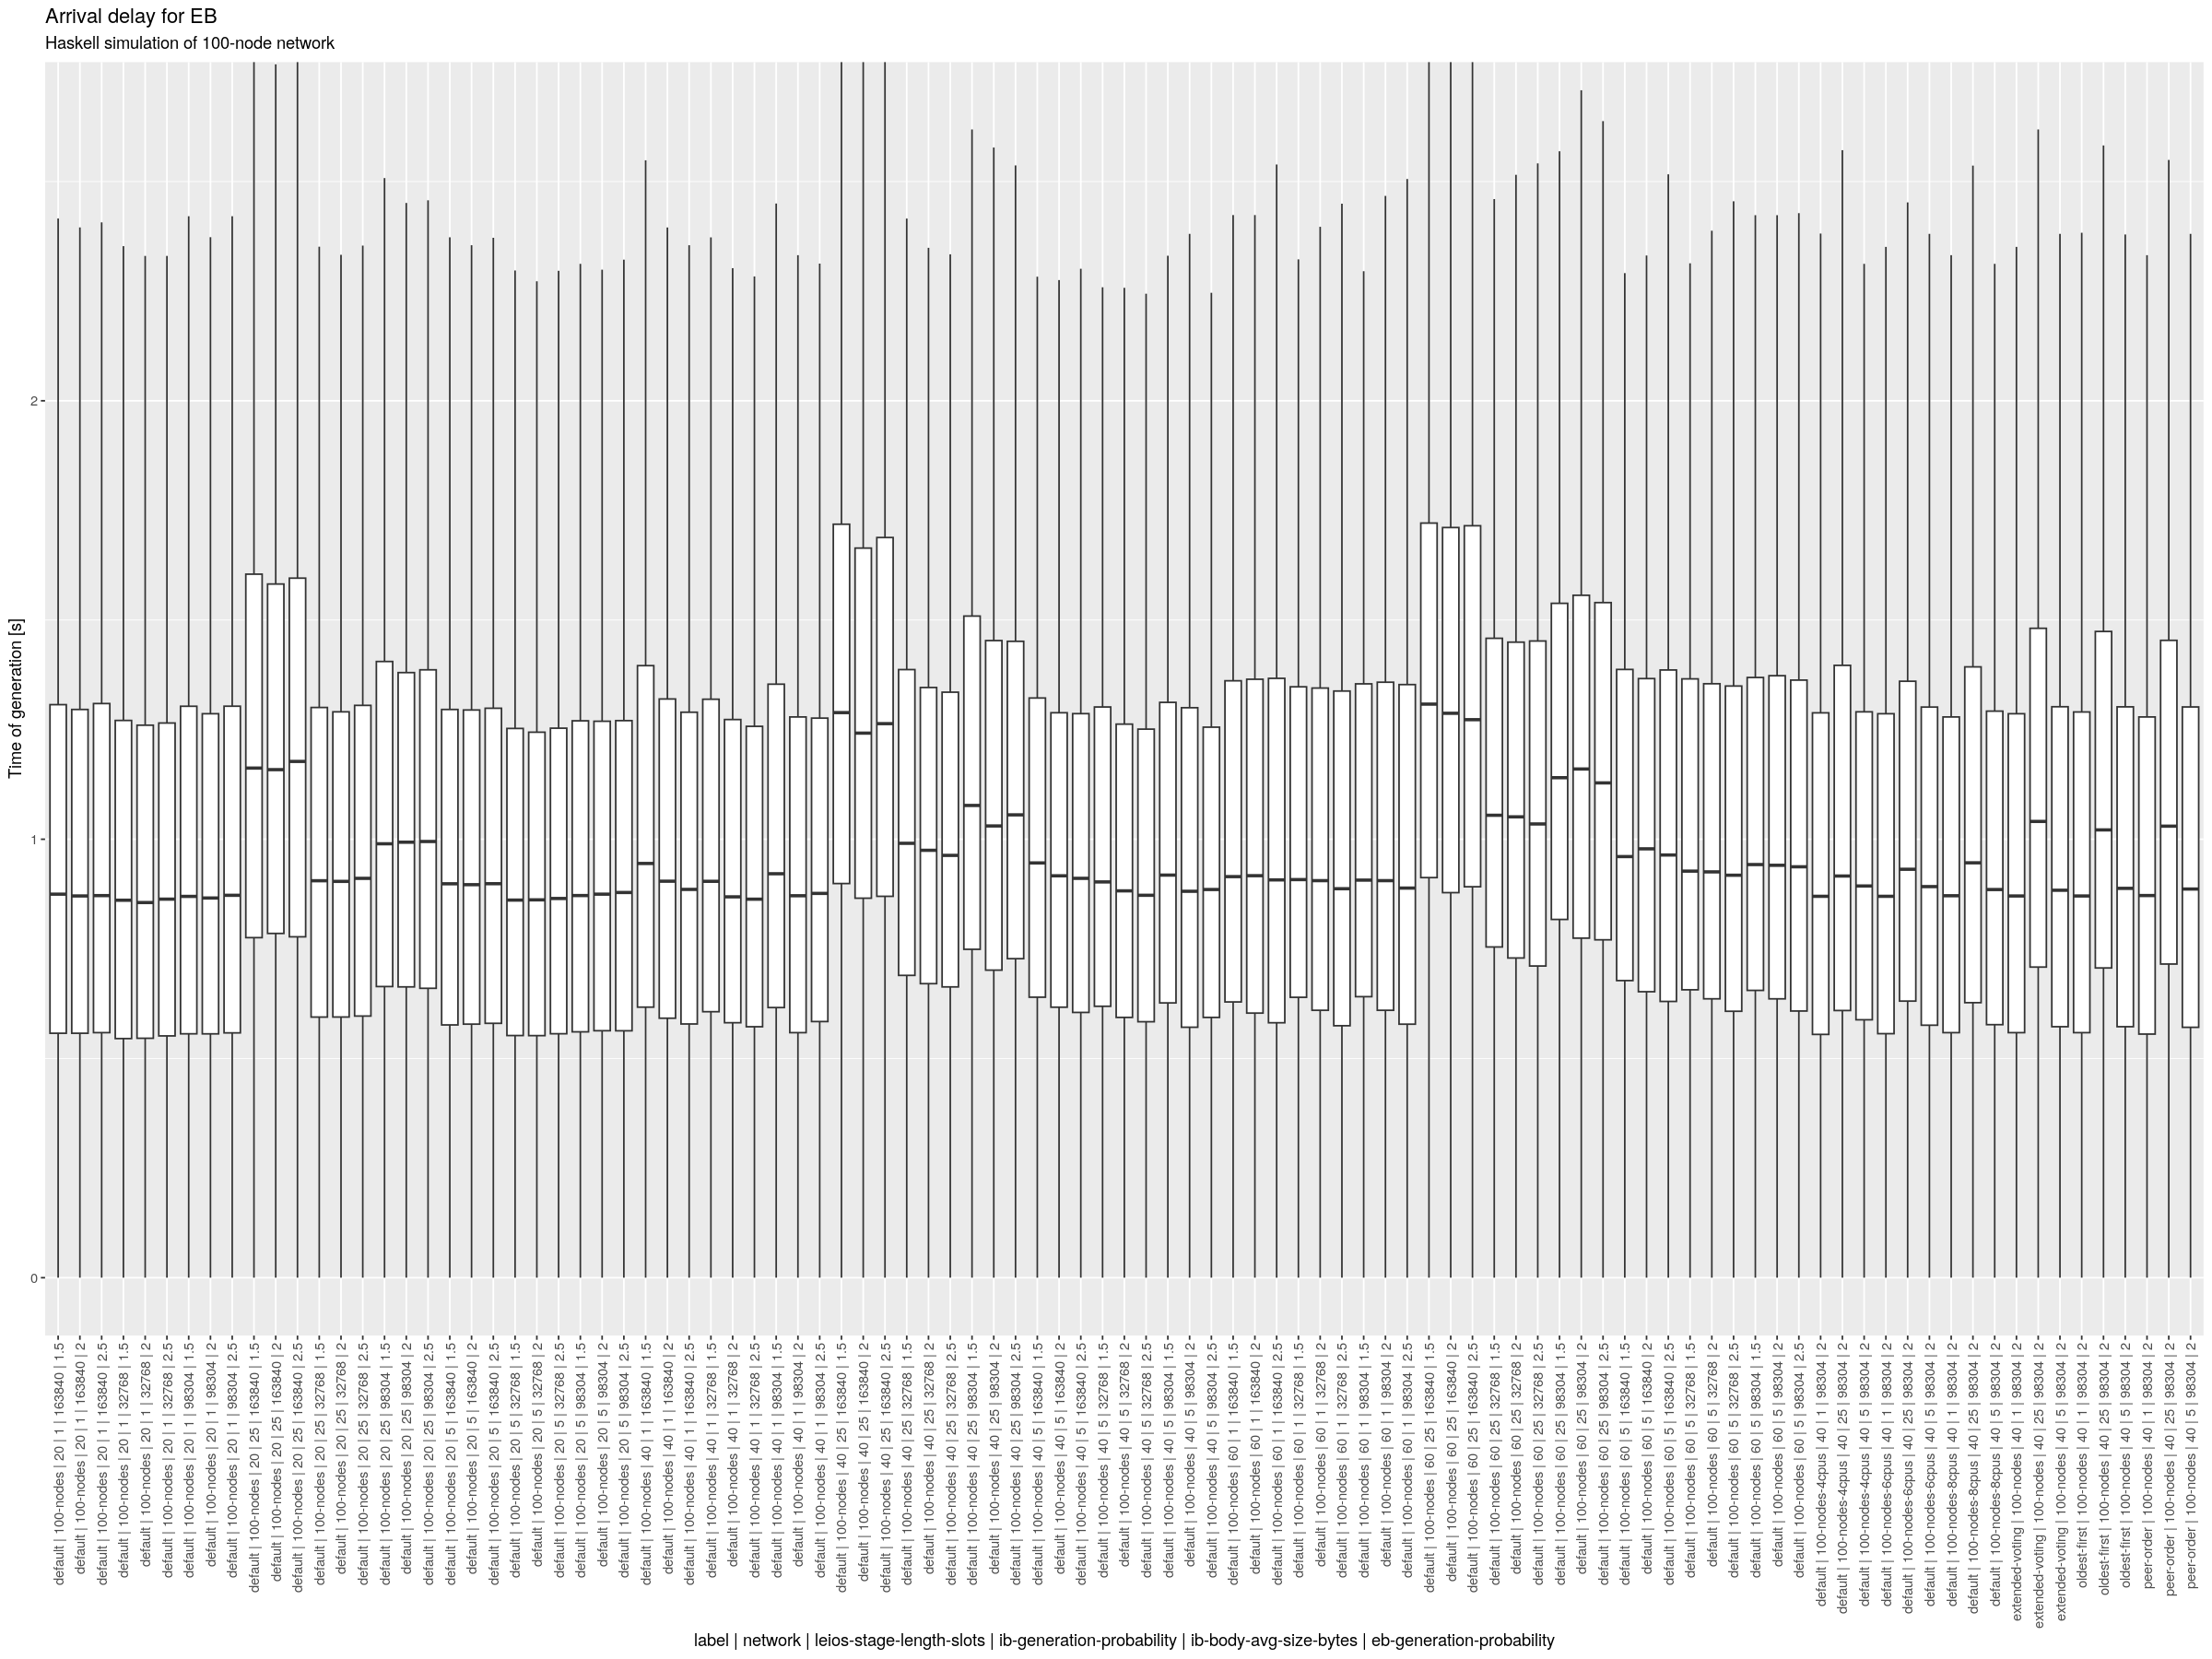

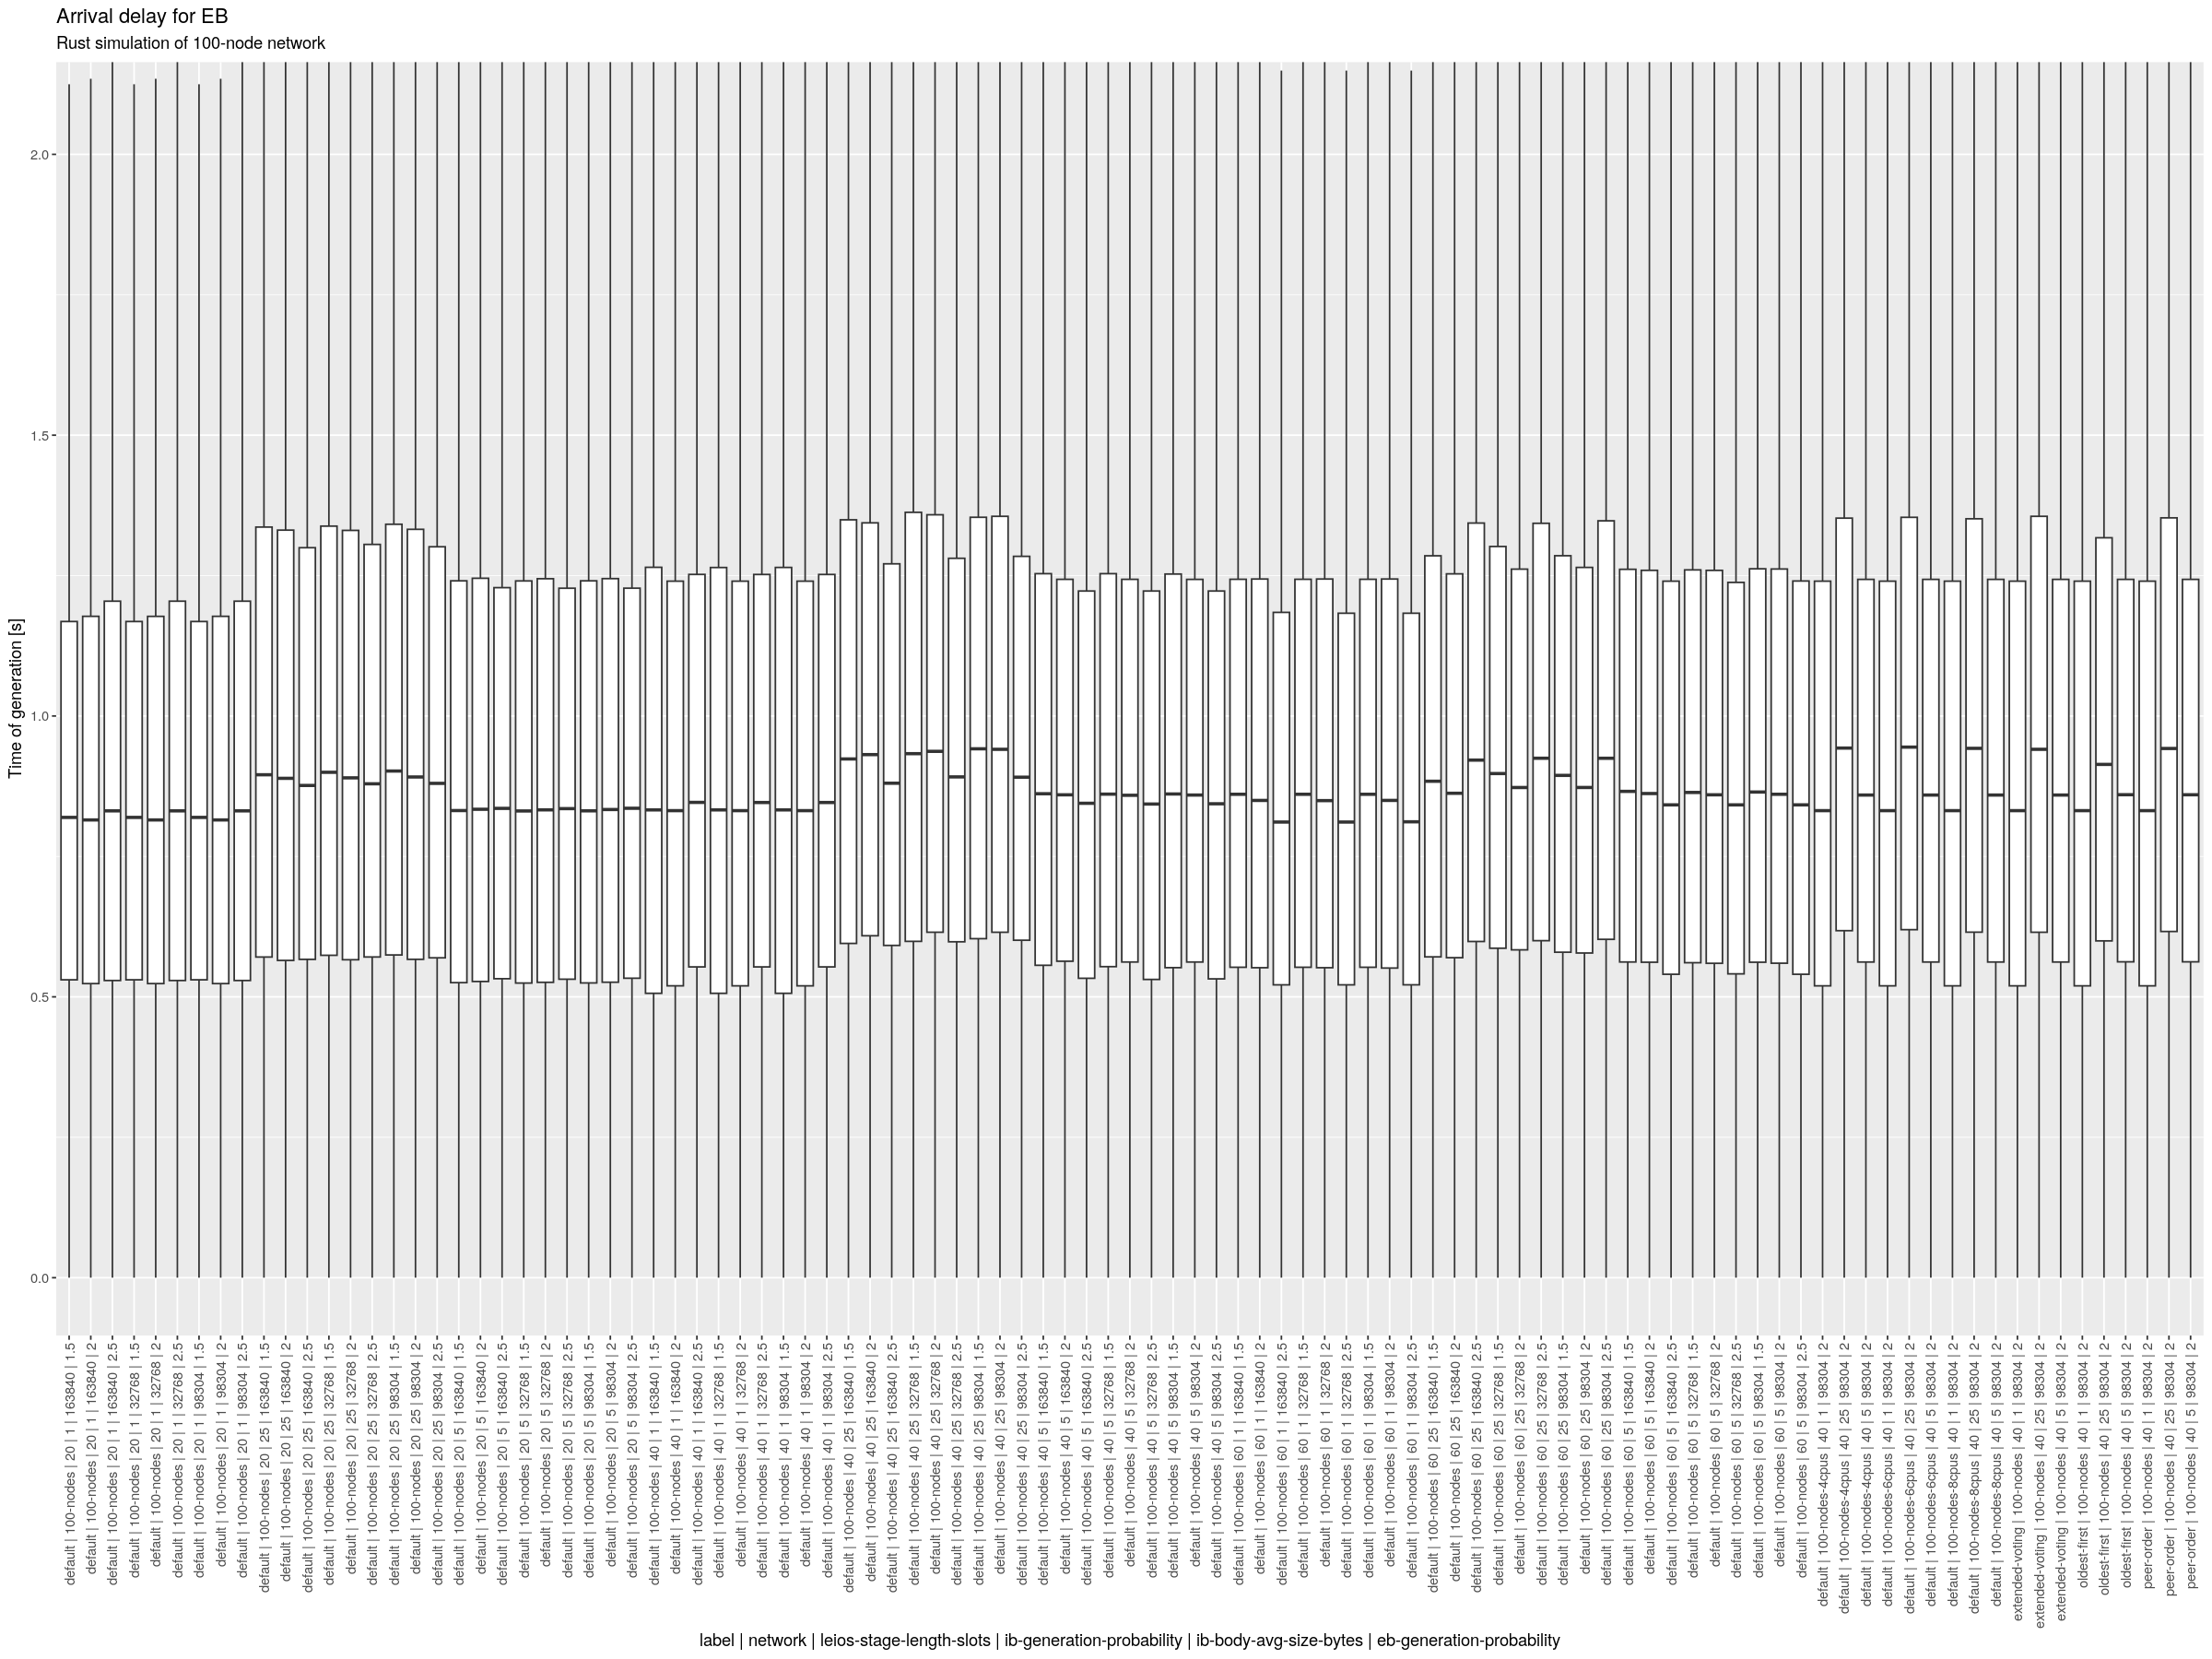

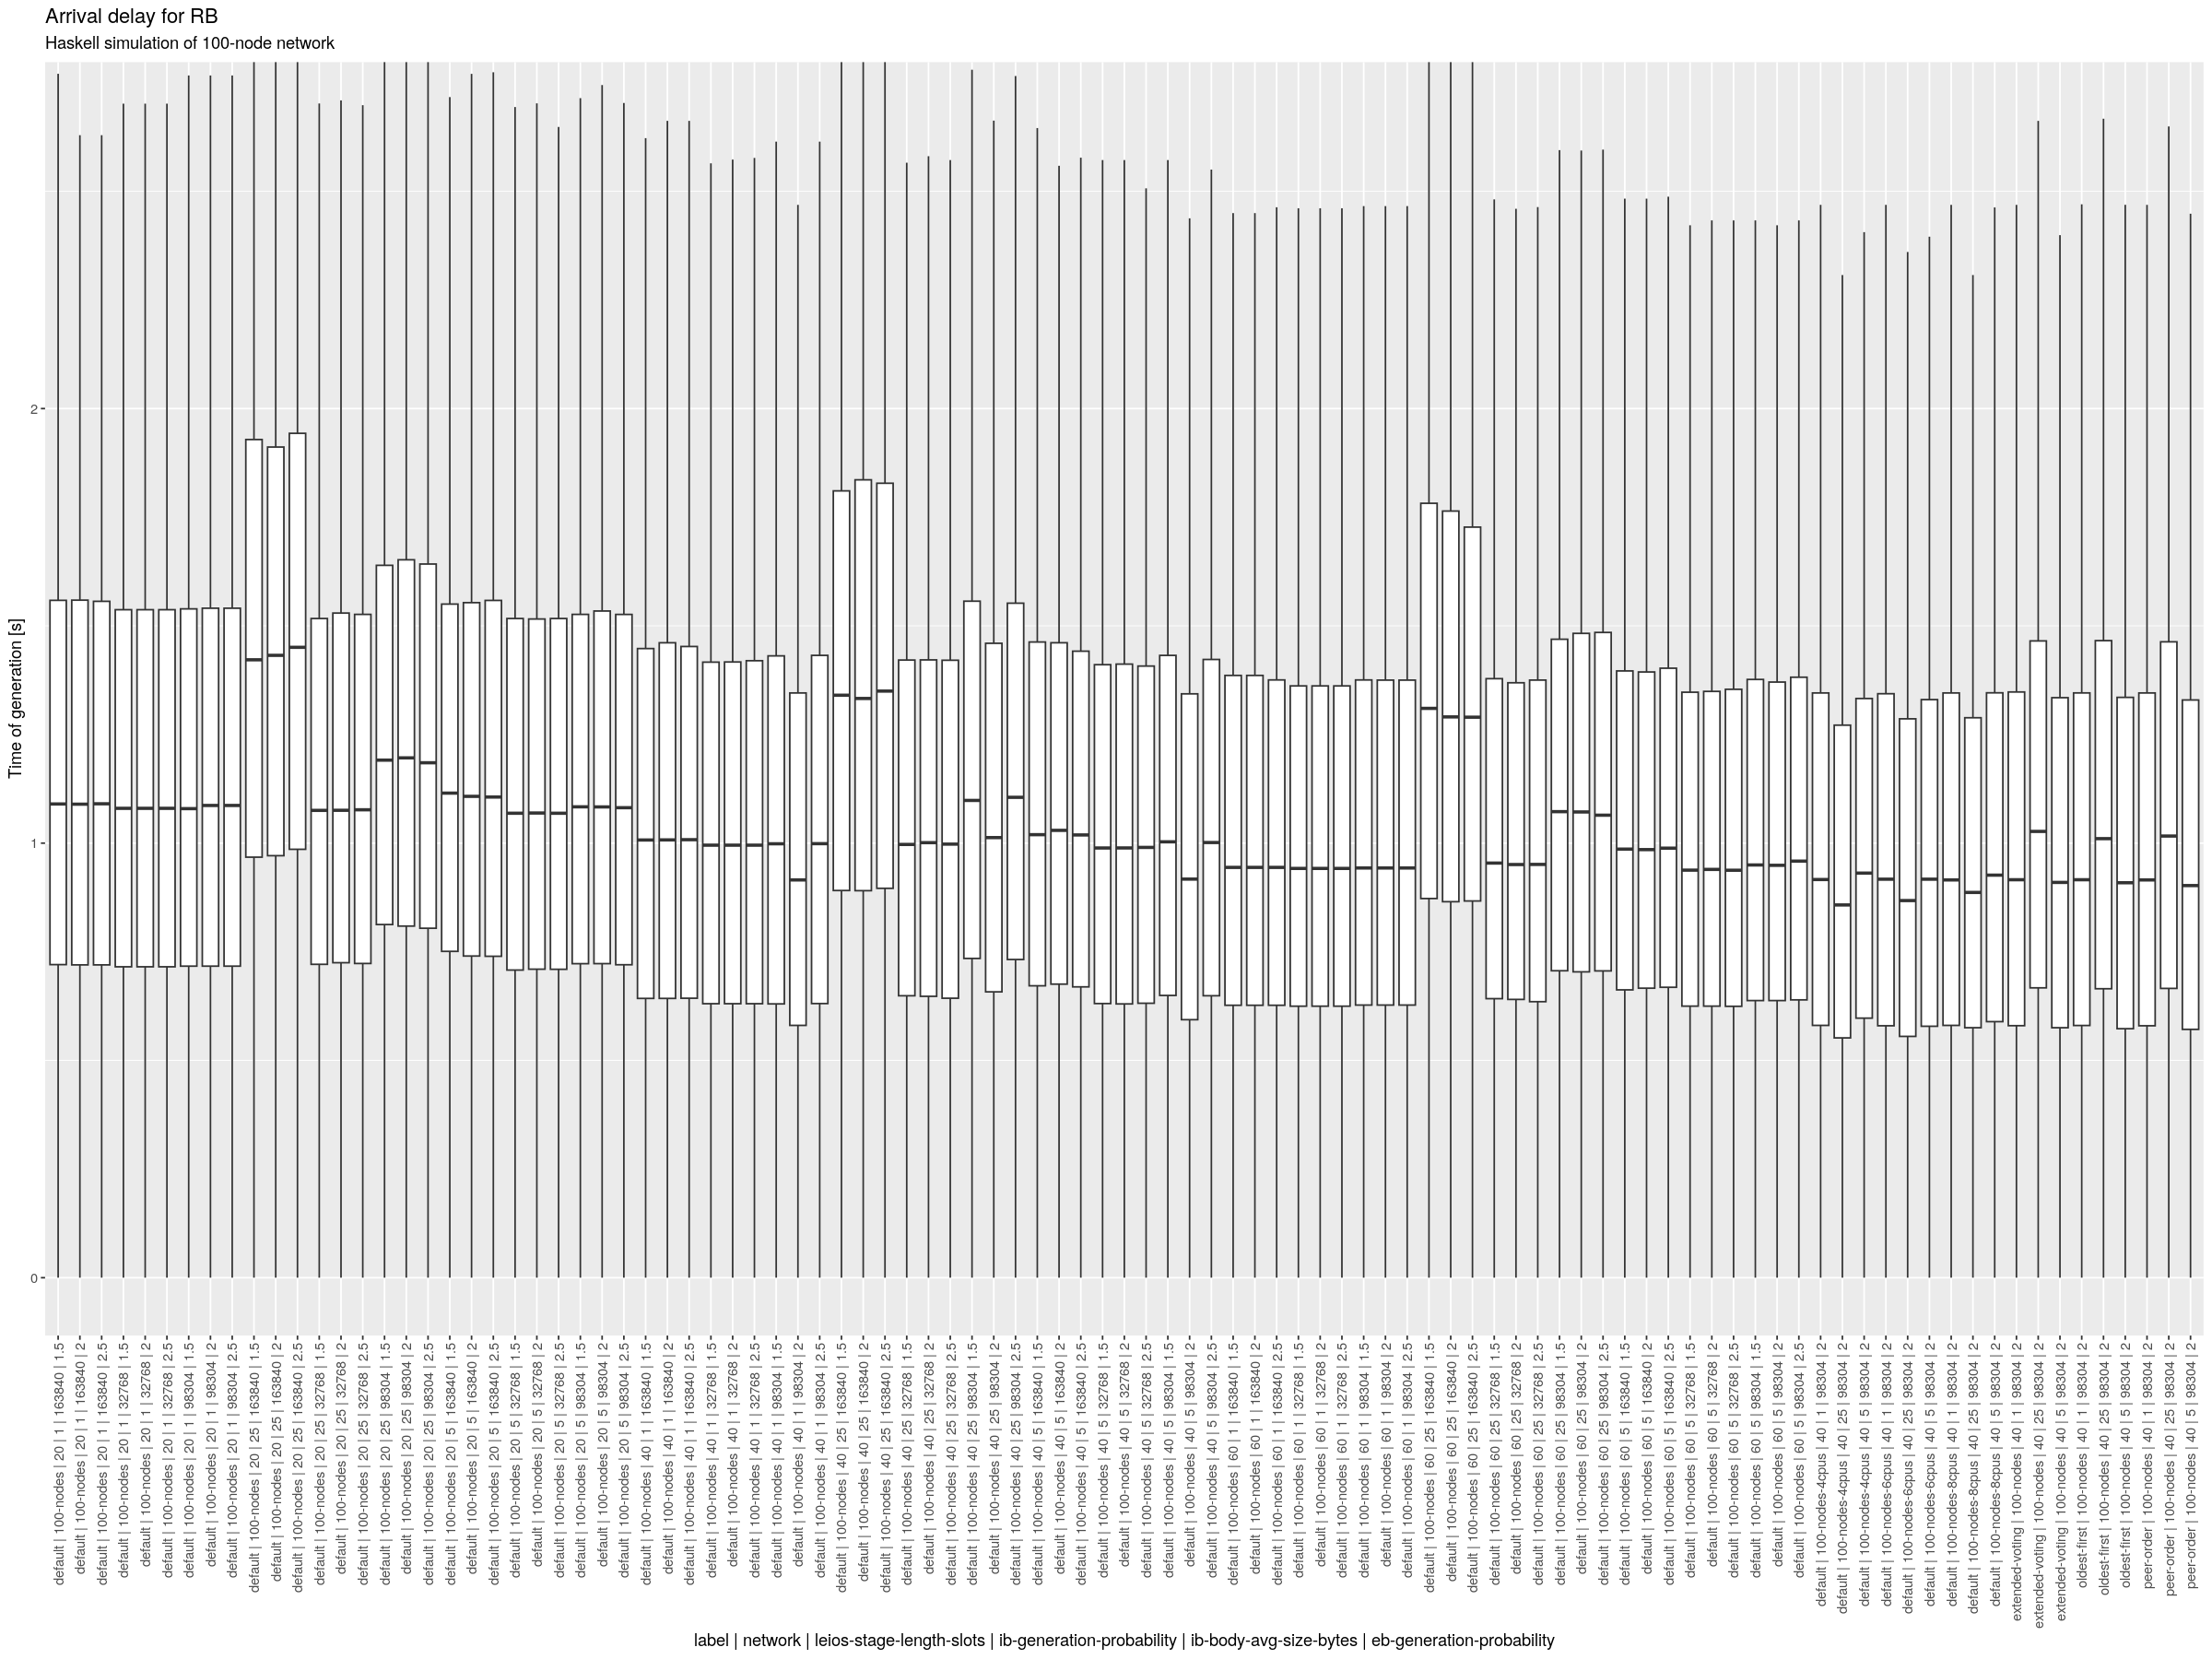

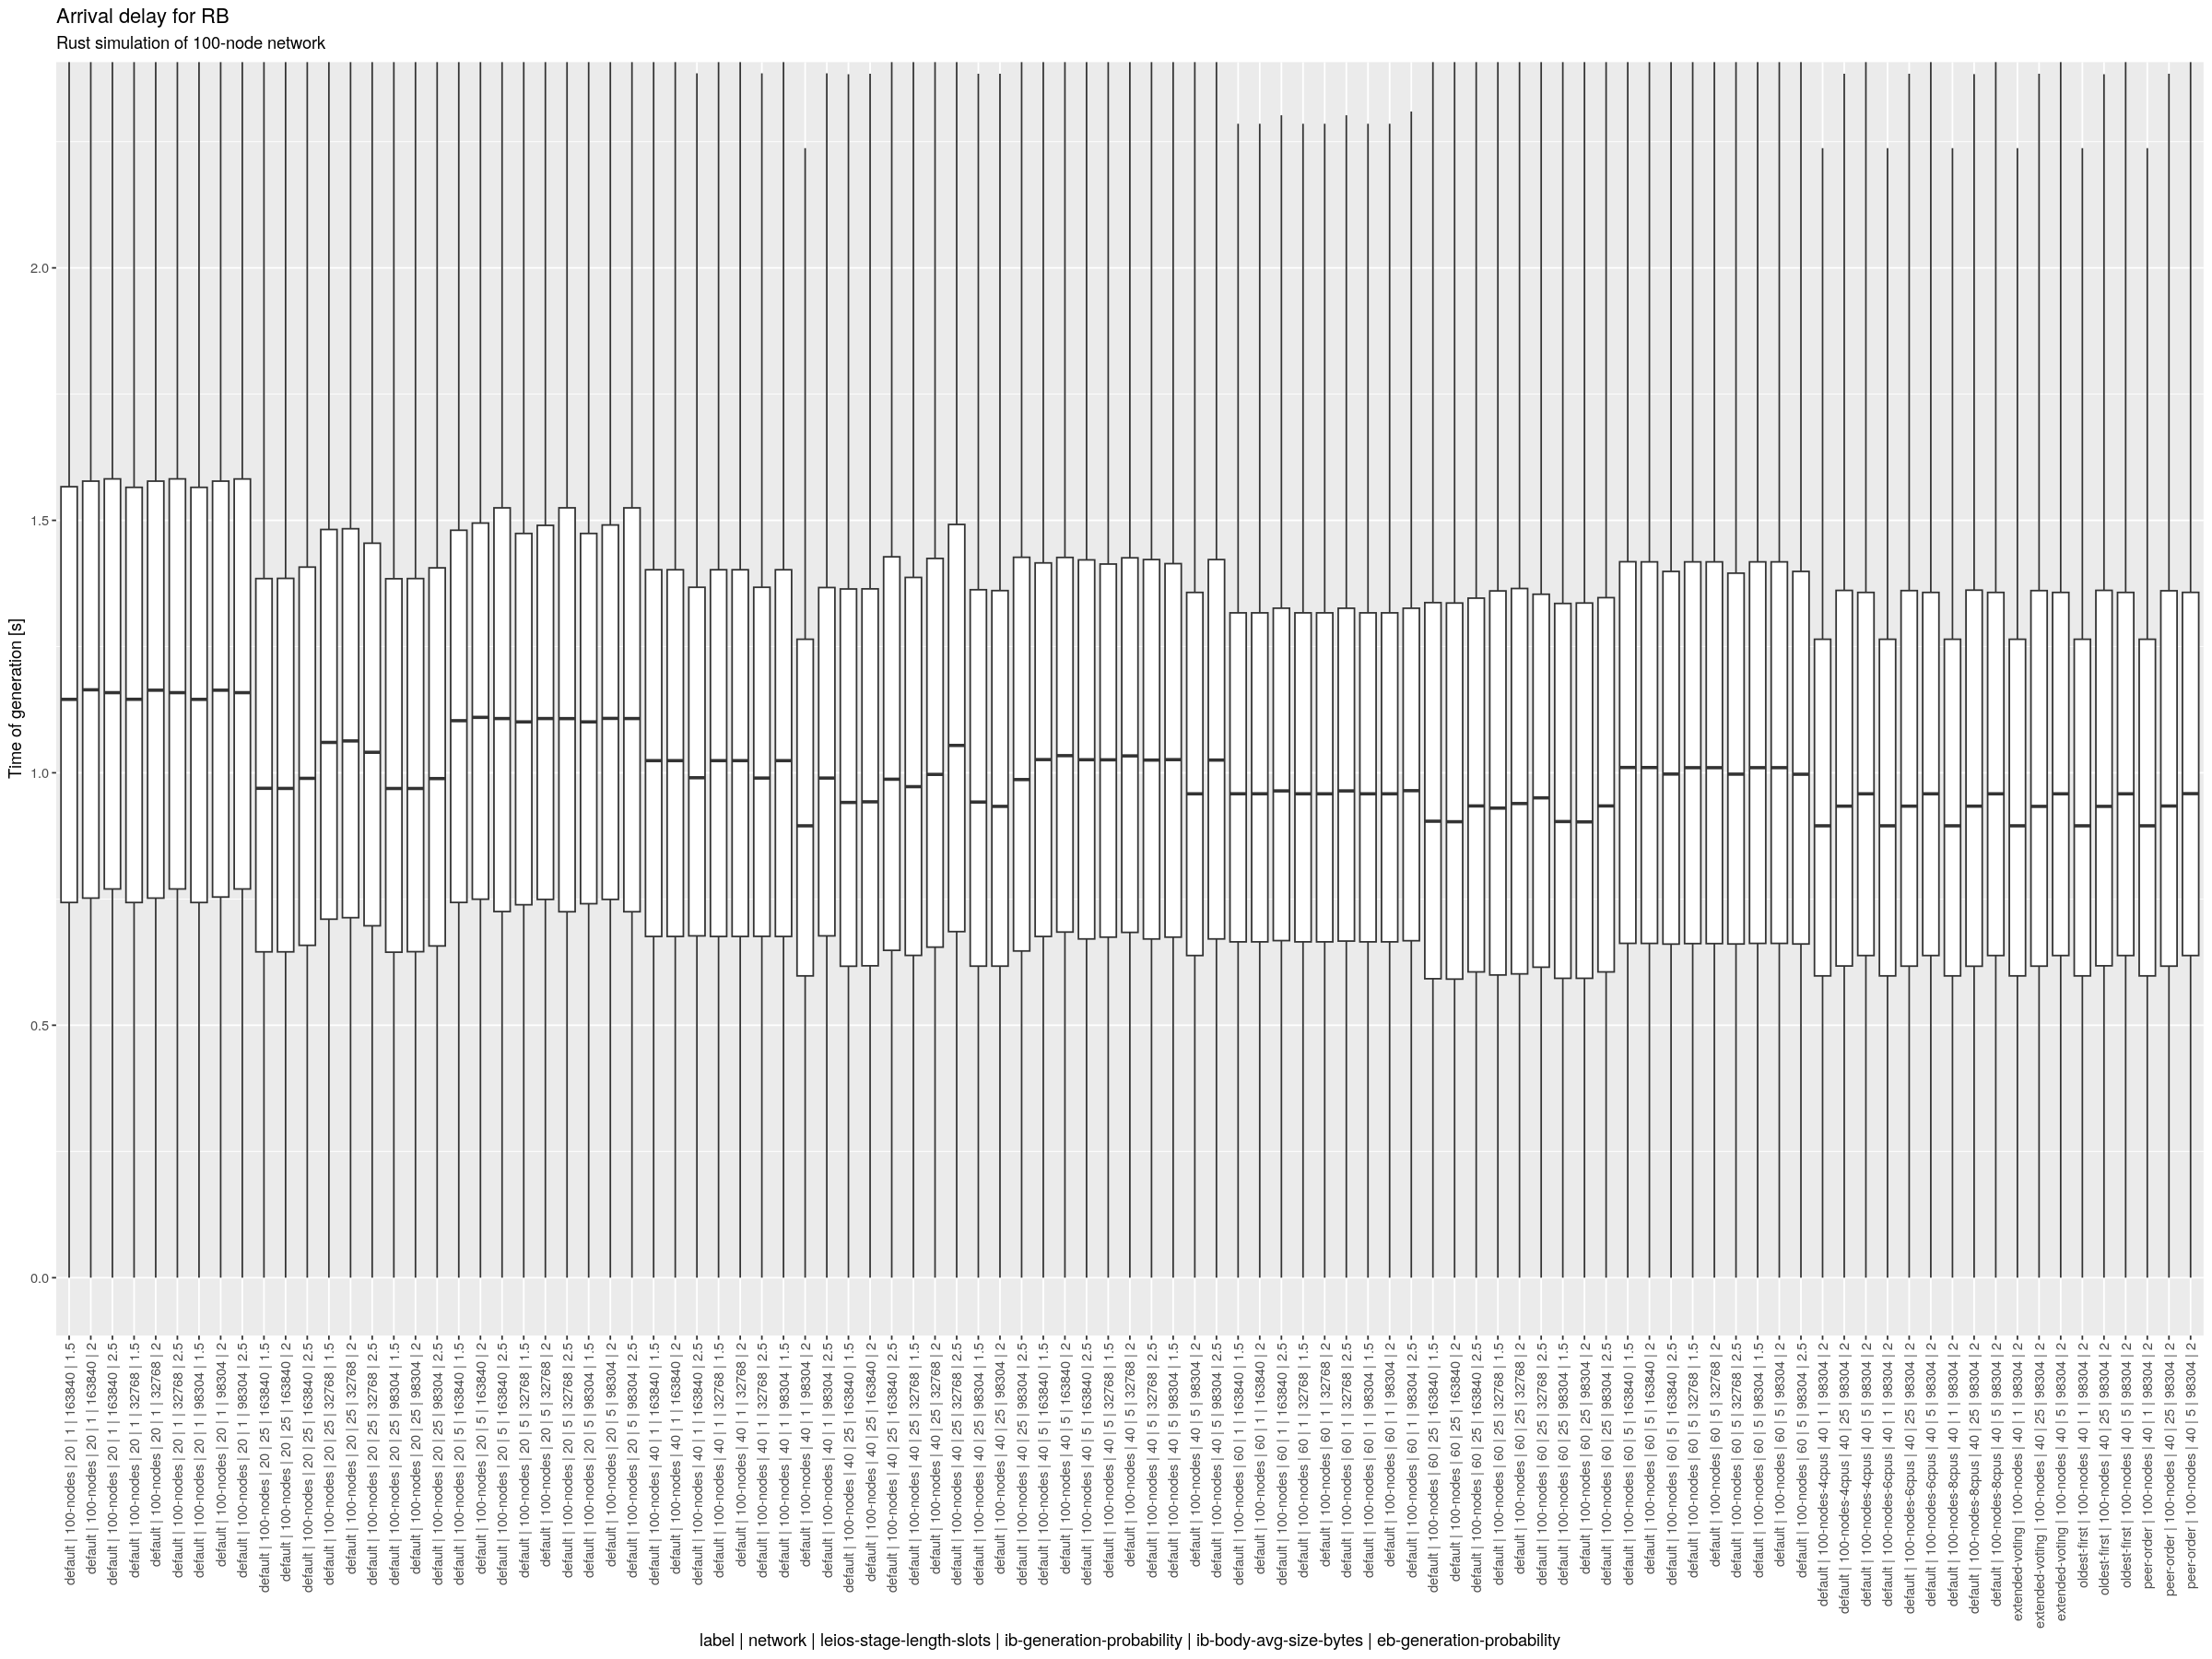

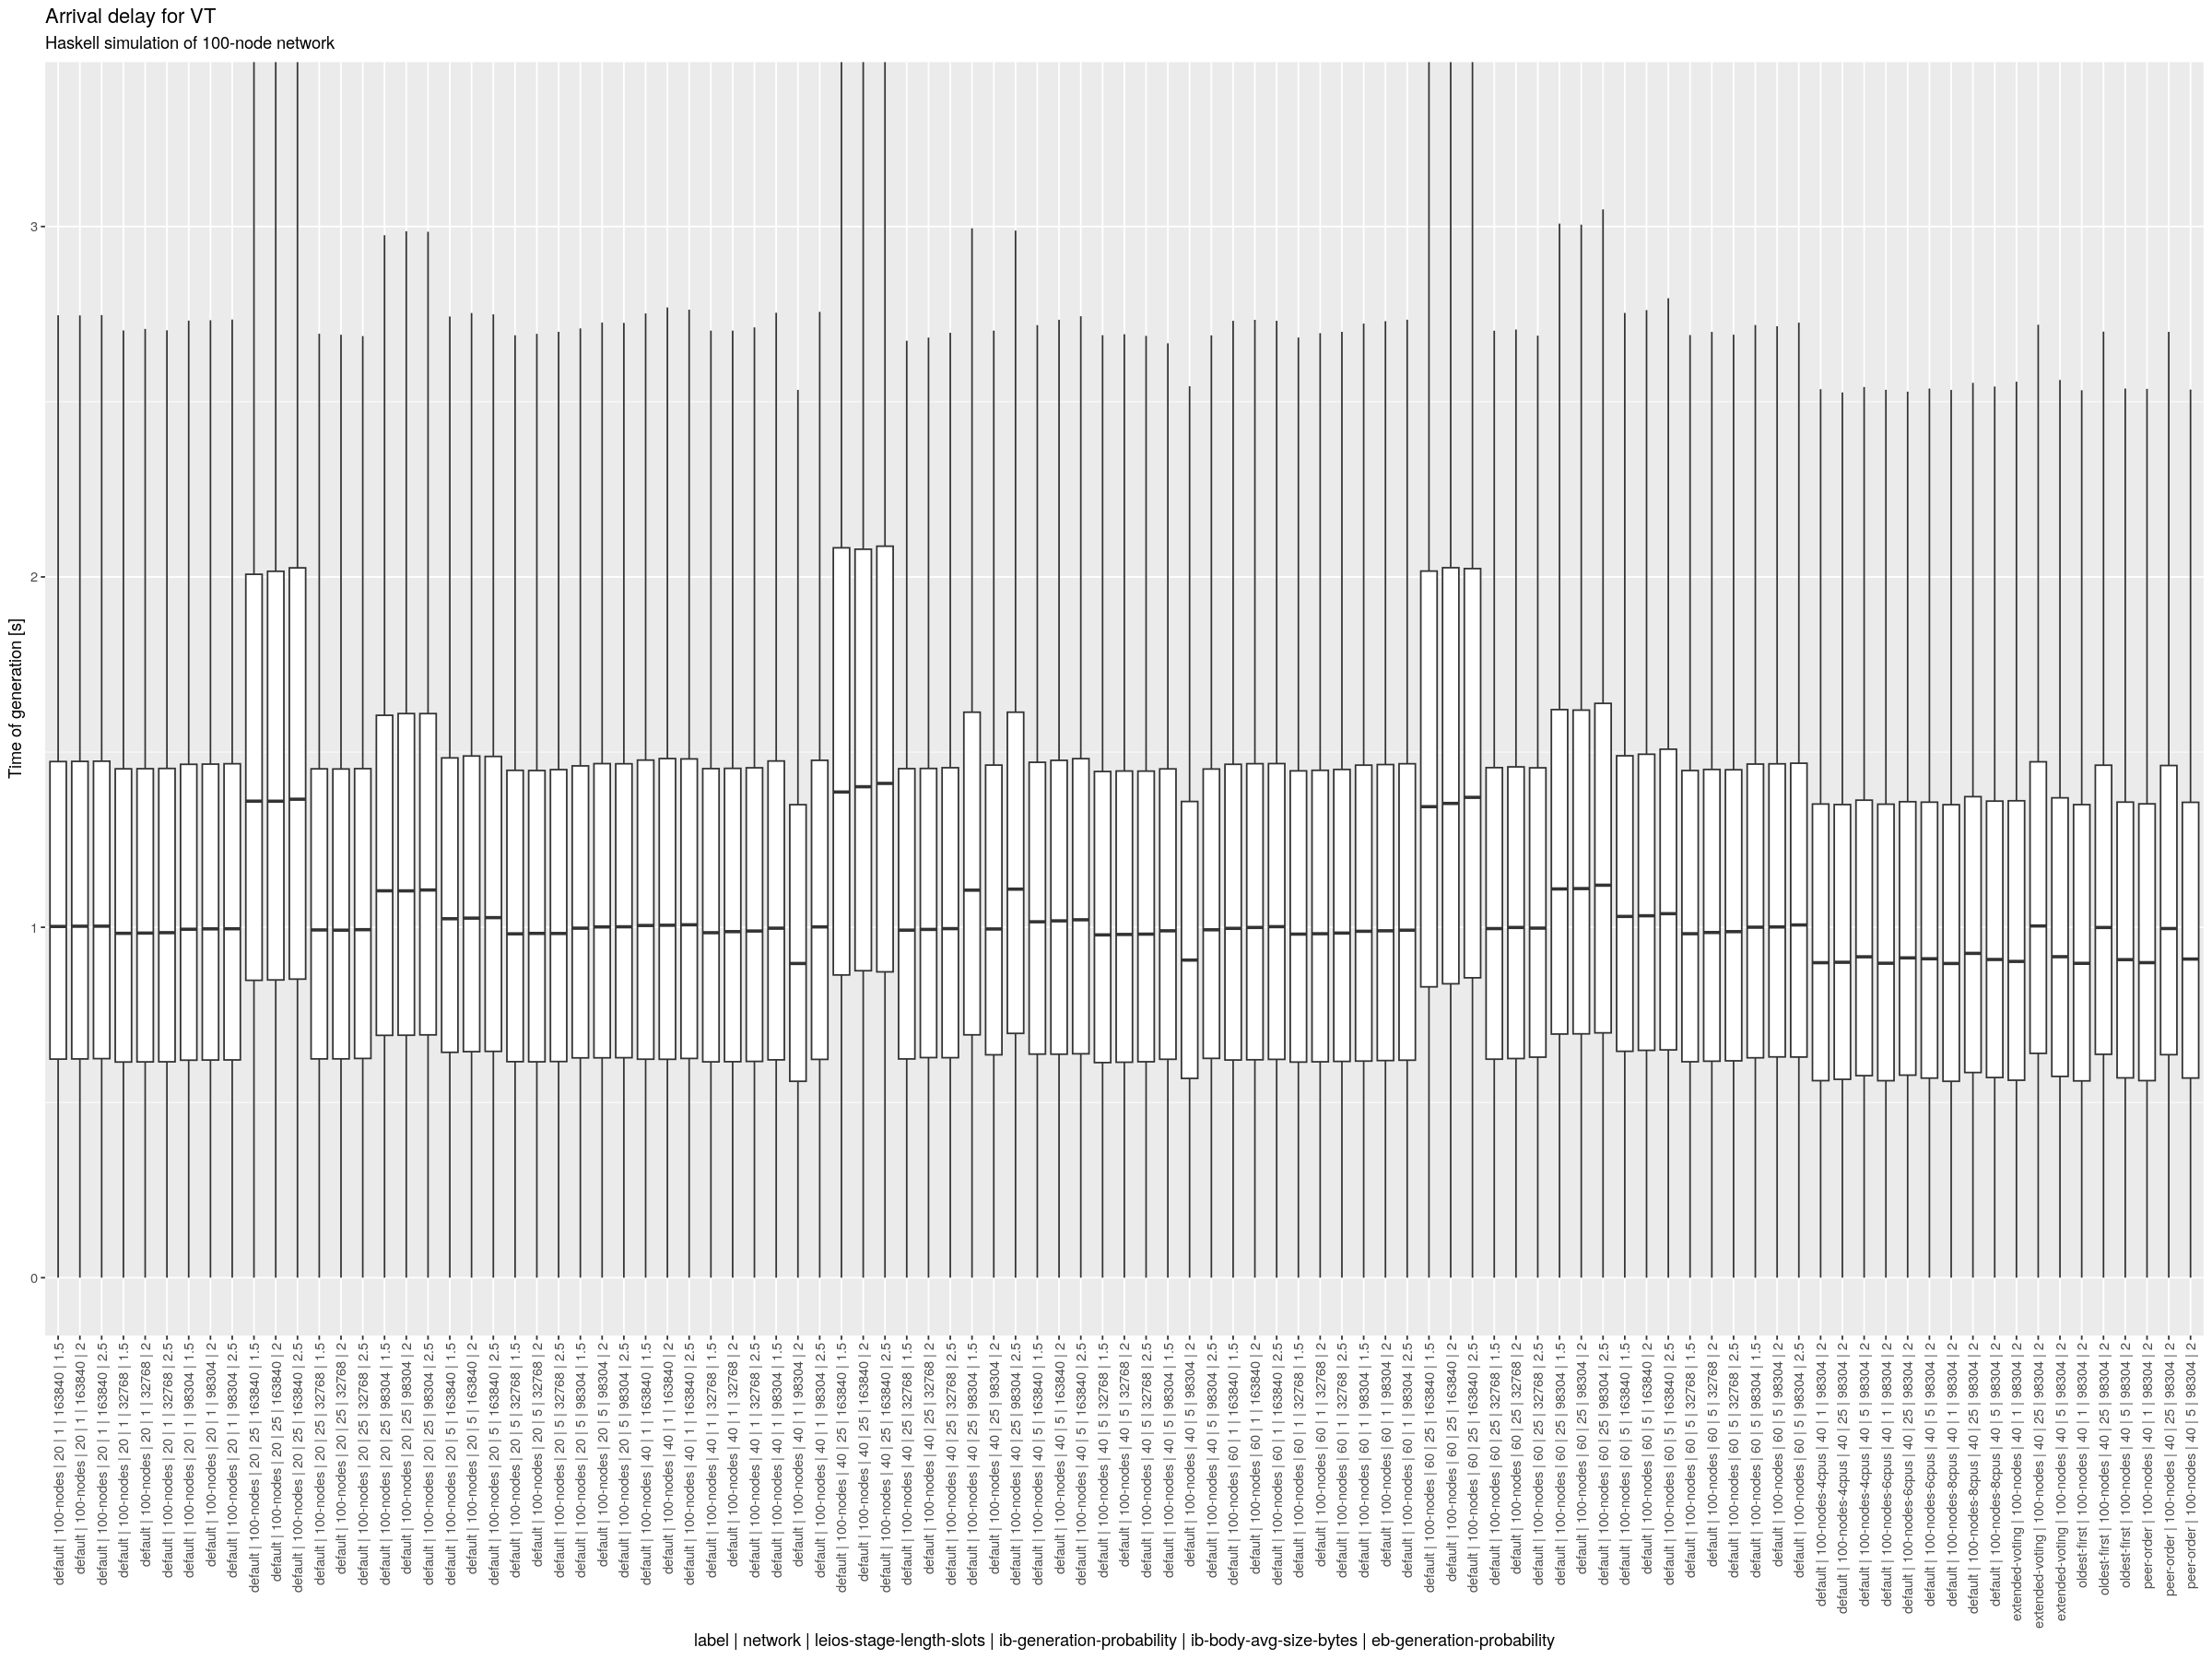

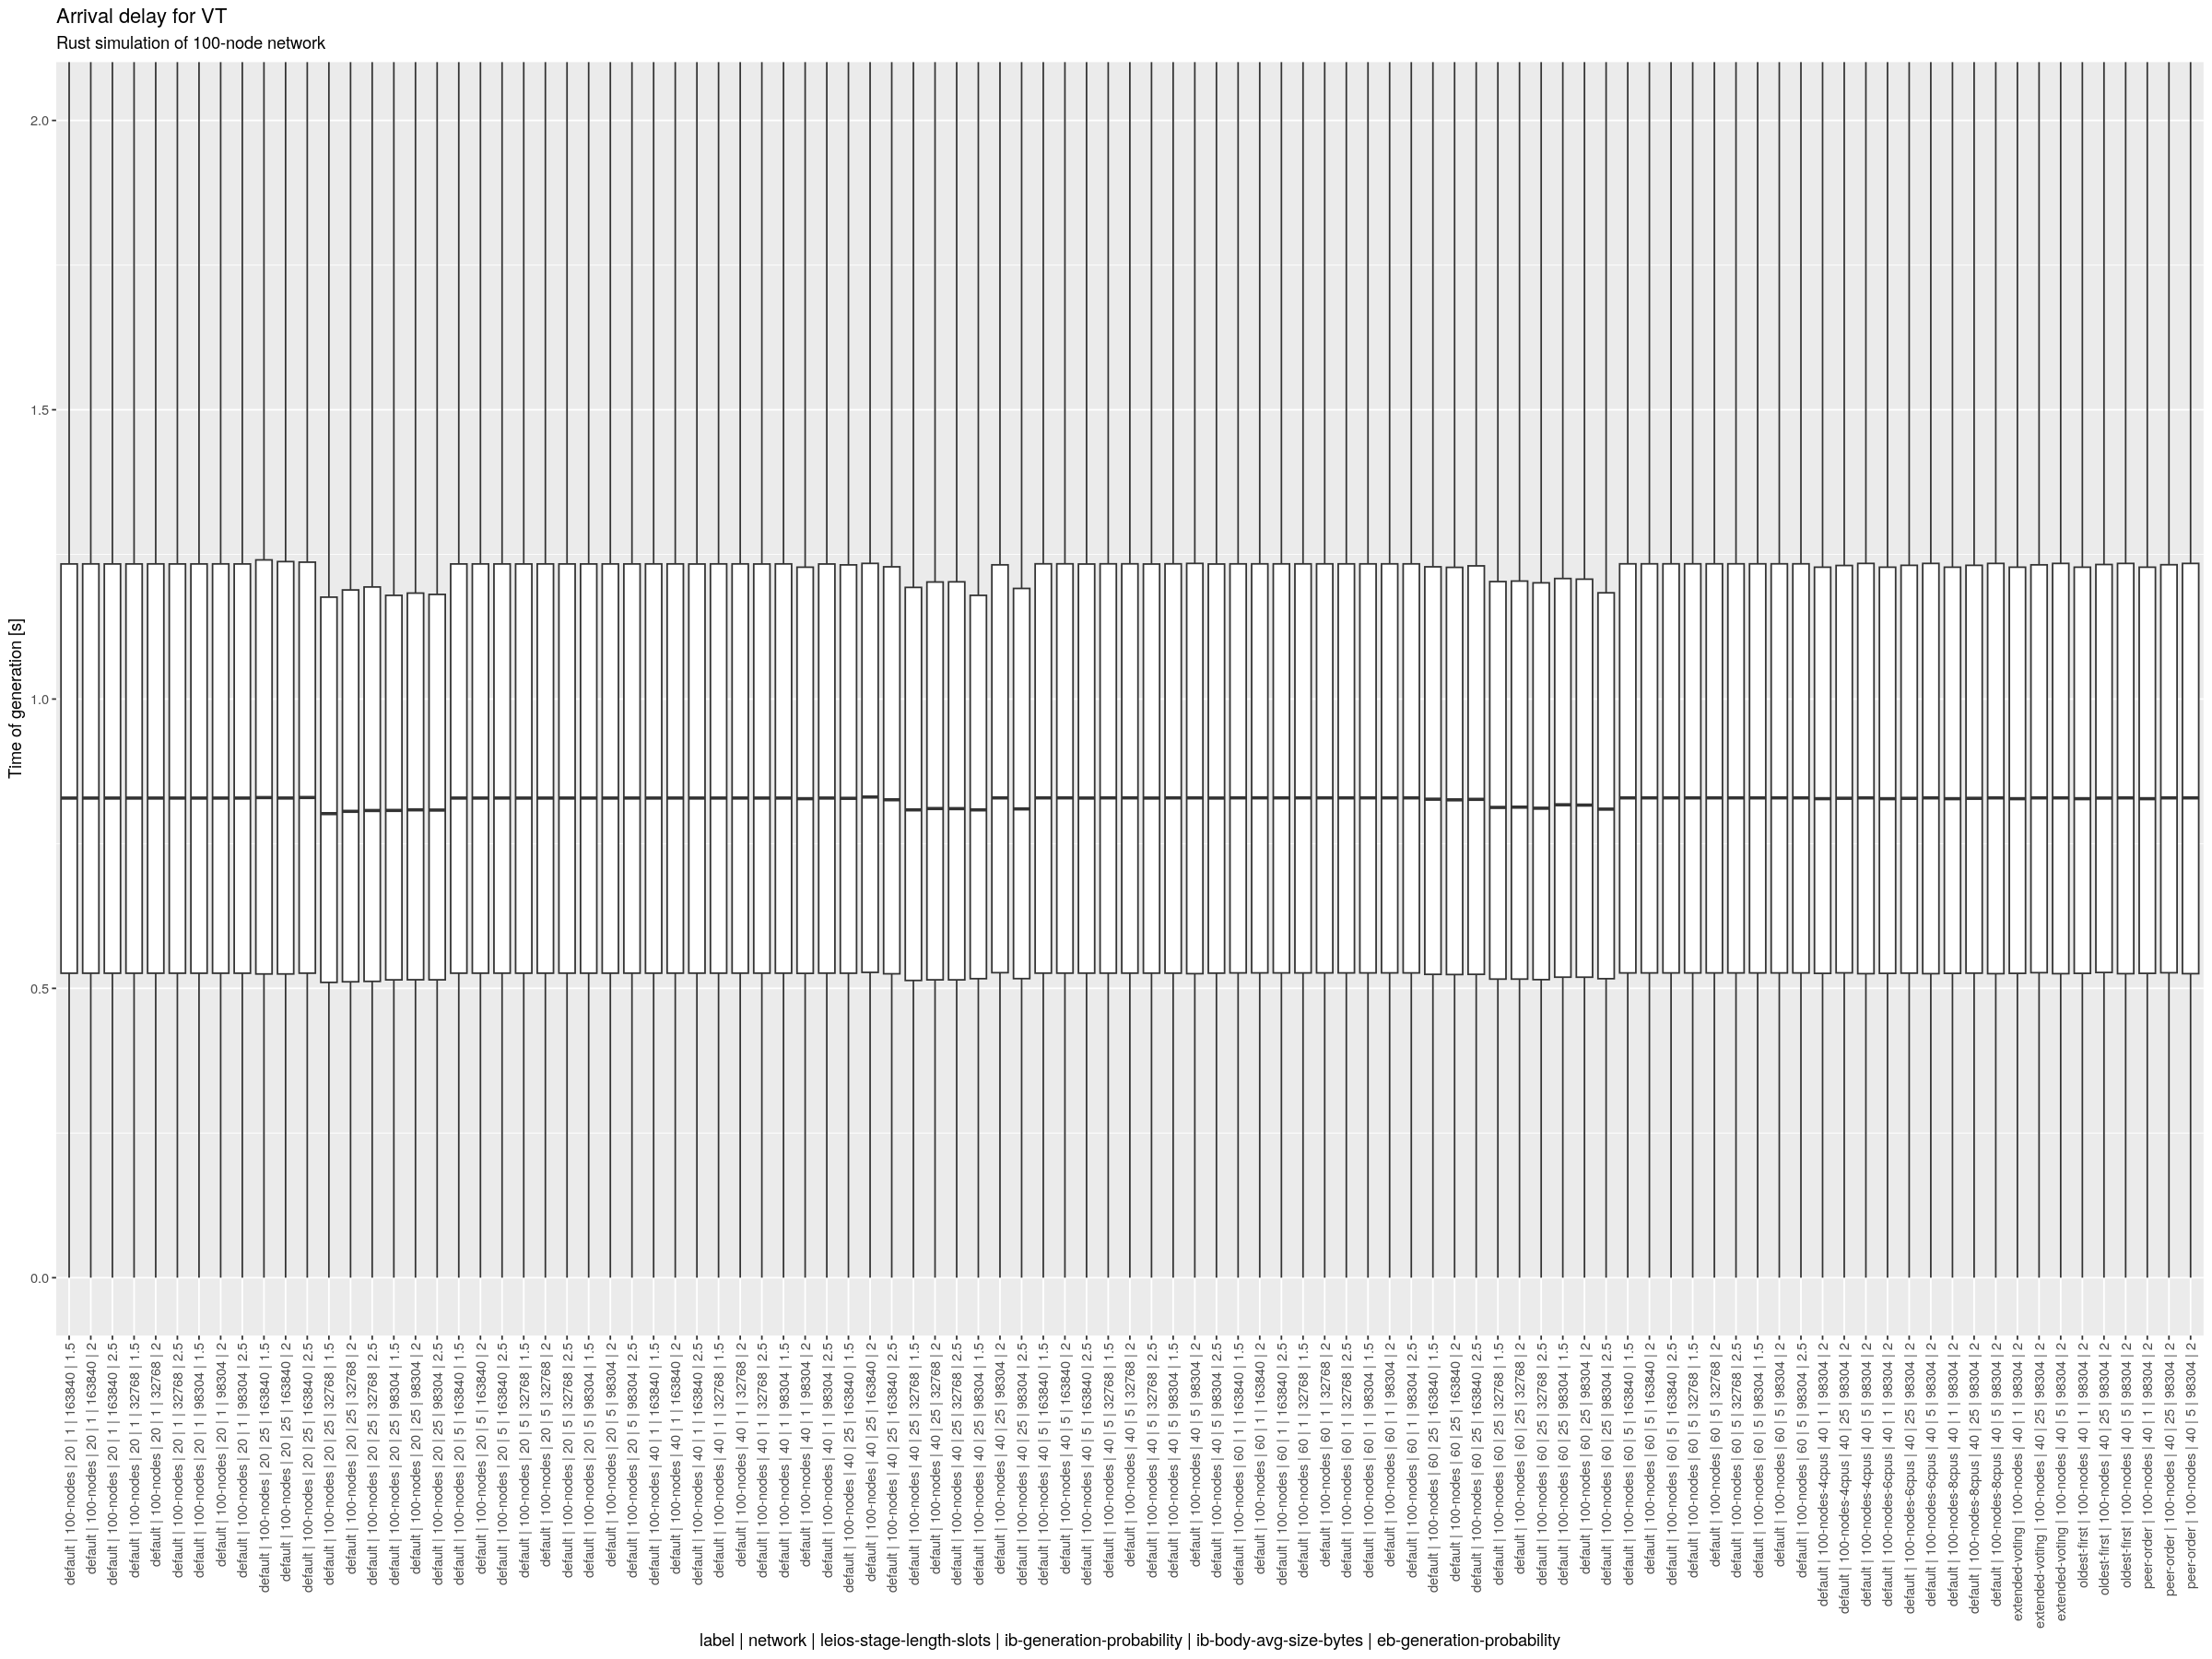

In [27]:
for (k in c("IB", "EB", "RB", "VT")) {
for (s in c("haskell", "rust")) {
    d <- receiptScenario[`simulator` == s & `kind` == k]
    g <- ggplot(d, aes(x=`scenario`, y=`elapsed`)) +
        geom_boxplot(outlier.shape=NA) +
        coord_cartesian(ylim=c(0, d[, quantile(`elapsed`, probs=0.99)])) +
        xlab("label | network | leios-stage-length-slots | ib-generation-probability | ib-body-avg-size-bytes | eb-generation-probability") +
        ylab("Time of generation [s]") +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) +
        ggtitle(paste("Arrival delay for", k), subtitle=paste(s %>% str_to_title, "simulation of 100-node network"))
    print(g)
    ggsave(paste0("plots/elapsed-boxplot-", k, "-", s, ".png"), units="in", width=15, height=6, dpi=150)
}
}